## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "sapu_DR", "sapu_UR", "sapu_DL", "sapu_UL",
    "suspicious_DR", "suspicious_UR", "suspicious_DL", "suspicious_UL",
#     "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct/NoDoor/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1794, 8, 36) (1794, 1) 295.26193 263.74173

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(13,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *2048
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 5.153962, Accuracy = 0.078125
PERFORMANCE ON TEST SET:             Batch Loss = 4.803411483764648, Accuracy = 0.05183946341276169
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.399740, Accuracy = 0.140625
PERFORMANCE ON TEST SET:             Batch Loss = 4.318424701690674, Accuracy = 0.16722407937049866
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.323426, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 4.2428998947143555, Accuracy = 0.20345596969127655
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 3.985185, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 4.0608229637146, Accuracy = 0.24358974397182465
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 4.146709, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 4.015429496765137, Accuracy = 0.25752508640289307
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.881934, Accuracy = 0.25
PERFO

Iter #23040:  Learning rate = 0.005000:   Batch Loss = 3.329566, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 3.383653163909912, Accuracy = 0.26309922337532043
Iter #23552:  Learning rate = 0.005000:   Batch Loss = 3.600012, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 3.4135611057281494, Accuracy = 0.2686733603477478
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 3.542240, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 3.401047706604004, Accuracy = 0.26811593770980835
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 3.386281, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 3.372749090194702, Accuracy = 0.27982163429260254
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 3.411838, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 3.3172407150268555, Accuracy = 0.2943143844604492
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 3.324896, Accuracy = 0.2

Iter #46080:  Learning rate = 0.005000:   Batch Loss = 2.922259, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.9736714363098145, Accuracy = 0.32998883724212646
Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.831230, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.949068307876587, Accuracy = 0.325529545545578
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.952517, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.9369421005249023, Accuracy = 0.3049052357673645
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.963578, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.91510009765625, Accuracy = 0.33946487307548523
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.836611, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.912668466567993, Accuracy = 0.348940908908844
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.738101, Accuracy = 0.39

Iter #69120:  Learning rate = 0.005000:   Batch Loss = 2.916575, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 3.0456182956695557, Accuracy = 0.2865105867385864
Iter #69632:  Learning rate = 0.005000:   Batch Loss = 3.156788, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.097196578979492, Accuracy = 0.27591973543167114
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.947848, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.9610788822174072, Accuracy = 0.29933109879493713
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 2.746846, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 3.013428211212158, Accuracy = 0.2664436995983124
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 3.046039, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.9920668601989746, Accuracy = 0.2881828248500824
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.887075, Accuracy = 0.

Iter #92160:  Learning rate = 0.005000:   Batch Loss = 2.662287, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.657957077026367, Accuracy = 0.35562989115715027
Iter #92672:  Learning rate = 0.005000:   Batch Loss = 2.472009, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.6557931900024414, Accuracy = 0.3606466054916382
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 2.566628, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.6433537006378174, Accuracy = 0.3678929805755615
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 2.655114, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6223978996276855, Accuracy = 0.3745819330215454
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.535629, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.597294807434082, Accuracy = 0.4007803797721863
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.452474, Accuracy = 0.

Iter #115200:  Learning rate = 0.004800:   Batch Loss = 2.424972, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.46937894821167, Accuracy = 0.4002229571342468
Iter #115712:  Learning rate = 0.004800:   Batch Loss = 2.392413, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4871511459350586, Accuracy = 0.3979932963848114
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 2.241322, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.427598714828491, Accuracy = 0.44147157669067383
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 2.518604, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.4728519916534424, Accuracy = 0.40746933221817017
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 2.201877, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.421515941619873, Accuracy = 0.4392419159412384
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 2.634557, Accuracy = 0.

Iter #138240:  Learning rate = 0.004800:   Batch Loss = 2.454621, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.338637590408325, Accuracy = 0.4498327672481537
Iter #138752:  Learning rate = 0.004800:   Batch Loss = 2.463511, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.365741491317749, Accuracy = 0.43979933857917786
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 2.490370, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.354851007461548, Accuracy = 0.4331103563308716
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 2.594417, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3349697589874268, Accuracy = 0.4481605291366577
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 2.252083, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3482046127319336, Accuracy = 0.4470457136631012
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 2.386754, Accurac

Iter #161280:  Learning rate = 0.004800:   Batch Loss = 2.352255, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2098634243011475, Accuracy = 0.4899665415287018
Iter #161792:  Learning rate = 0.004800:   Batch Loss = 2.111688, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.233940601348877, Accuracy = 0.4665551781654358
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 2.272334, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2198662757873535, Accuracy = 0.46934226155281067
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 2.144330, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.227644920349121, Accuracy = 0.4687848389148712
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 2.320364, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.236727714538574, Accuracy = 0.4626532793045044
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 2.242733, Accuracy =

Iter #184320:  Learning rate = 0.004800:   Batch Loss = 2.244307, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.279001474380493, Accuracy = 0.4342252016067505
Iter #184832:  Learning rate = 0.004800:   Batch Loss = 2.424874, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.280022382736206, Accuracy = 0.4314381182193756
Iter #185344:  Learning rate = 0.004800:   Batch Loss = 2.317020, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.277573347091675, Accuracy = 0.43589743971824646
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 2.284609, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2647182941436768, Accuracy = 0.4403567314147949
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 2.372065, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.232287883758545, Accuracy = 0.4537346661090851
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 2.292327, Accuracy = 0

Iter #207360:  Learning rate = 0.004608:   Batch Loss = 2.310303, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3965201377868652, Accuracy = 0.4147157073020935
Iter #207872:  Learning rate = 0.004608:   Batch Loss = 2.438874, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.366851329803467, Accuracy = 0.4314381182193756
Iter #208384:  Learning rate = 0.004608:   Batch Loss = 2.322239, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3235456943511963, Accuracy = 0.4470457136631012
Iter #208896:  Learning rate = 0.004608:   Batch Loss = 2.234220, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3063759803771973, Accuracy = 0.4247491657733917
Iter #209408:  Learning rate = 0.004608:   Batch Loss = 2.185449, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.306725025177002, Accuracy = 0.43199554085731506
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 2.254542, Accurac

Iter #230400:  Learning rate = 0.004608:   Batch Loss = 2.558741, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 2.455467700958252, Accuracy = 0.3433667719364166
Iter #230912:  Learning rate = 0.004608:   Batch Loss = 2.396376, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4004709720611572, Accuracy = 0.3835005462169647
Iter #231424:  Learning rate = 0.004608:   Batch Loss = 2.281928, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3533413410186768, Accuracy = 0.3773690164089203
Iter #231936:  Learning rate = 0.004608:   Batch Loss = 2.218282, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3466739654541016, Accuracy = 0.40914157032966614
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 2.161202, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.295618772506714, Accuracy = 0.43088072538375854
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 2.437012, Accuracy 

Iter #253440:  Learning rate = 0.004608:   Batch Loss = 2.453624, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3568756580352783, Accuracy = 0.4007803797721863
Iter #253952:  Learning rate = 0.004608:   Batch Loss = 2.463626, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3699405193328857, Accuracy = 0.4085841774940491
Iter #254464:  Learning rate = 0.004608:   Batch Loss = 2.316001, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3378262519836426, Accuracy = 0.4041248559951782
Iter #254976:  Learning rate = 0.004608:   Batch Loss = 2.337815, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.3083853721618652, Accuracy = 0.4225195050239563
Iter #255488:  Learning rate = 0.004608:   Batch Loss = 2.173139, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.305530548095703, Accuracy = 0.42419174313545227
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 2.304225, Accuracy

Iter #276480:  Learning rate = 0.004608:   Batch Loss = 2.114904, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1575560569763184, Accuracy = 0.4726867377758026
Iter #276992:  Learning rate = 0.004608:   Batch Loss = 2.134387, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1672348976135254, Accuracy = 0.4520624279975891
Iter #277504:  Learning rate = 0.004608:   Batch Loss = 2.277955, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.12920880317688, Accuracy = 0.4832775890827179
Iter #278016:  Learning rate = 0.004608:   Batch Loss = 2.249266, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1127071380615234, Accuracy = 0.47380155324935913
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 2.230021, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.144552230834961, Accuracy = 0.46989965438842773
Iter #279040:  Learning rate = 0.004608:   Batch Loss = 2.372245, Accuracy 

Iter #299520:  Learning rate = 0.004608:   Batch Loss = 2.326562, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1084537506103516, Accuracy = 0.4882943034172058
Iter #300032:  Learning rate = 0.004424:   Batch Loss = 2.176625, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1283161640167236, Accuracy = 0.4654403626918793
Iter #300544:  Learning rate = 0.004424:   Batch Loss = 2.168437, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.188772201538086, Accuracy = 0.4509476125240326
Iter #301056:  Learning rate = 0.004424:   Batch Loss = 1.948859, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.21708607673645, Accuracy = 0.4381271004676819
Iter #301568:  Learning rate = 0.004424:   Batch Loss = 2.385352, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.168724536895752, Accuracy = 0.47101449966430664
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 2.237414, Accuracy =

Iter #322560:  Learning rate = 0.004424:   Batch Loss = 1.971030, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2226006984710693, Accuracy = 0.44648829102516174
Iter #323072:  Learning rate = 0.004424:   Batch Loss = 2.267822, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.198045253753662, Accuracy = 0.44648829102516174
Iter #323584:  Learning rate = 0.004424:   Batch Loss = 2.229694, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2037575244903564, Accuracy = 0.4459308683872223
Iter #324096:  Learning rate = 0.004424:   Batch Loss = 2.215288, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2012808322906494, Accuracy = 0.44481605291366577
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 2.168358, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.177250385284424, Accuracy = 0.44648829102516174
Iter #325120:  Learning rate = 0.004424:   Batch Loss = 2.204678, Accu

Iter #345600:  Learning rate = 0.004424:   Batch Loss = 2.184866, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2584047317504883, Accuracy = 0.41304346919059753
Iter #346112:  Learning rate = 0.004424:   Batch Loss = 2.180981, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2021524906158447, Accuracy = 0.4420289993286133
Iter #346624:  Learning rate = 0.004424:   Batch Loss = 2.180665, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1949806213378906, Accuracy = 0.43756967782974243
Iter #347136:  Learning rate = 0.004424:   Batch Loss = 2.257235, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.173859119415283, Accuracy = 0.44147157669067383
Iter #347648:  Learning rate = 0.004424:   Batch Loss = 2.174876, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1695468425750732, Accuracy = 0.45652174949645996
Iter #348160:  Learning rate = 0.004424:   Batch Loss = 2.076320, Accurac

Iter #369152:  Learning rate = 0.004424:   Batch Loss = 2.654980, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2889537811279297, Accuracy = 0.40133780241012573
Iter #369664:  Learning rate = 0.004424:   Batch Loss = 2.147241, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.200411319732666, Accuracy = 0.4481605291366577
Iter #370176:  Learning rate = 0.004424:   Batch Loss = 2.125193, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1560275554656982, Accuracy = 0.45317724347114563
Iter #370688:  Learning rate = 0.004424:   Batch Loss = 2.264863, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1370410919189453, Accuracy = 0.454849511384964
Iter #371200:  Learning rate = 0.004424:   Batch Loss = 2.132350, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1160902976989746, Accuracy = 0.46711260080337524
Iter #371712:  Learning rate = 0.004424:   Batch Loss = 2.079832, Accuracy = 0.5

Iter #392704:  Learning rate = 0.004424:   Batch Loss = 2.067534, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.053802728652954, Accuracy = 0.4793756902217865
Iter #393216:  Learning rate = 0.004424:   Batch Loss = 2.055921, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0468387603759766, Accuracy = 0.4910813868045807
Iter #393728:  Learning rate = 0.004424:   Batch Loss = 2.687237, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 2.4112370014190674, Accuracy = 0.36900779604911804
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 2.316380, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.2675671577453613, Accuracy = 0.4046822786331177
Iter #394752:  Learning rate = 0.004424:   Batch Loss = 2.276939, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1698925495147705, Accuracy = 0.4403567314147949
Iter #395264:  Learning rate = 0.004424:   Batch Loss = 2.409221, Accuracy 

Iter #415744:  Learning rate = 0.004247:   Batch Loss = 1.939991, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9877662658691406, Accuracy = 0.502229630947113
Iter #416256:  Learning rate = 0.004247:   Batch Loss = 2.024942, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9953503608703613, Accuracy = 0.4949832856655121
Iter #416768:  Learning rate = 0.004247:   Batch Loss = 1.941239, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.001098155975342, Accuracy = 0.4860646724700928
Iter #417280:  Learning rate = 0.004247:   Batch Loss = 1.911702, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.013044834136963, Accuracy = 0.46321070194244385
Iter #417792:  Learning rate = 0.004247:   Batch Loss = 2.028450, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0082414150238037, Accuracy = 0.4938684403896332
Iter #418304:  Learning rate = 0.004247:   Batch Loss = 2.013001, Accuracy = 0

Iter #438784:  Learning rate = 0.004247:   Batch Loss = 2.087186, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.130800724029541, Accuracy = 0.43756967782974243
Iter #439296:  Learning rate = 0.004247:   Batch Loss = 1.996999, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.163914442062378, Accuracy = 0.4381271004676819
Iter #439808:  Learning rate = 0.004247:   Batch Loss = 2.256339, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1390175819396973, Accuracy = 0.4208472669124603
Iter #440320:  Learning rate = 0.004247:   Batch Loss = 2.069510, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.1724953651428223, Accuracy = 0.4214046895503998
Iter #440832:  Learning rate = 0.004247:   Batch Loss = 2.177215, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.159973621368408, Accuracy = 0.4292084872722626
Iter #441344:  Learning rate = 0.004247:   Batch Loss = 2.085488, Accuracy = 0.4687

Iter #461824:  Learning rate = 0.004247:   Batch Loss = 1.872815, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9743390083312988, Accuracy = 0.5094760060310364
Iter #462336:  Learning rate = 0.004247:   Batch Loss = 1.748891, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0138299465179443, Accuracy = 0.4894091486930847
Iter #462848:  Learning rate = 0.004247:   Batch Loss = 1.845464, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0176444053649902, Accuracy = 0.4910813868045807
Iter #463360:  Learning rate = 0.004247:   Batch Loss = 1.886057, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0531795024871826, Accuracy = 0.47212931513786316
Iter #463872:  Learning rate = 0.004247:   Batch Loss = 1.977796, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.017927408218384, Accuracy = 0.49163880944252014
Iter #464384:  Learning rate = 0.004247:   Batch Loss = 1.927337, Accuracy = 0.4

Iter #484864:  Learning rate = 0.004247:   Batch Loss = 1.729532, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9420018196105957, Accuracy = 0.5139353275299072
Iter #485376:  Learning rate = 0.004247:   Batch Loss = 1.883251, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9582611322402954, Accuracy = 0.4860646724700928
Iter #485888:  Learning rate = 0.004247:   Batch Loss = 1.978480, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.944226861000061, Accuracy = 0.5
Iter #486400:  Learning rate = 0.004247:   Batch Loss = 2.061190, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9065340757369995, Accuracy = 0.5189520716667175
Iter #486912:  Learning rate = 0.004247:   Batch Loss = 1.963890, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.95387864112854, Accuracy = 0.5133779048919678
Iter #487424:  Learning rate = 0.004247:   Batch Loss = 2.100936, Accuracy = 0.40625
PERFORMANC

Iter #507904:  Learning rate = 0.004077:   Batch Loss = 2.074878, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9869556427001953, Accuracy = 0.4921962022781372
Iter #508416:  Learning rate = 0.004077:   Batch Loss = 1.958369, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9948216676712036, Accuracy = 0.4855072498321533
Iter #508928:  Learning rate = 0.004077:   Batch Loss = 1.817727, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9378596544265747, Accuracy = 0.519509494304657
Iter #509440:  Learning rate = 0.004077:   Batch Loss = 1.923954, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8900296688079834, Accuracy = 0.5050167441368103
Iter #509952:  Learning rate = 0.004077:   Batch Loss = 1.613443, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.89876389503479, Accuracy = 0.5172798037528992
Iter #510464:  Learning rate = 0.004077:   Batch Loss = 1.872074, Accuracy = 0.4375
PERF

Iter #530944:  Learning rate = 0.004077:   Batch Loss = 1.820940, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8752964735031128, Accuracy = 0.5295429229736328
Iter #531456:  Learning rate = 0.004077:   Batch Loss = 1.626812, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8494653701782227, Accuracy = 0.5334448218345642
Iter #531968:  Learning rate = 0.004077:   Batch Loss = 2.000934, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8455780744552612, Accuracy = 0.5440356731414795
Iter #532480:  Learning rate = 0.004077:   Batch Loss = 1.803872, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8550232648849487, Accuracy = 0.5273132920265198
Iter #532992:  Learning rate = 0.004077:   Batch Loss = 1.792019, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8628954887390137, Accuracy = 0.5484949946403503
Iter #533504:  Learning rate = 0.004077:   Batch Loss = 1.876301, Accuracy

Iter #553984:  Learning rate = 0.004077:   Batch Loss = 1.820484, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8573999404907227, Accuracy = 0.5390189290046692
Iter #554496:  Learning rate = 0.004077:   Batch Loss = 1.784024, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.850761890411377, Accuracy = 0.5373467206954956
Iter #555008:  Learning rate = 0.004077:   Batch Loss = 1.874271, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.849370002746582, Accuracy = 0.546822726726532
Iter #555520:  Learning rate = 0.004077:   Batch Loss = 1.967290, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.87430739402771, Accuracy = 0.5284280776977539
Iter #556032:  Learning rate = 0.004077:   Batch Loss = 1.866121, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8548574447631836, Accuracy = 0.5395763516426086
Iter #556544:  Learning rate = 0.004077:   Batch Loss = 1.904859, Accuracy = 0.5

Iter #577024:  Learning rate = 0.004077:   Batch Loss = 1.805039, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.848104476928711, Accuracy = 0.5278706550598145
Iter #577536:  Learning rate = 0.004077:   Batch Loss = 1.873688, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8283138275146484, Accuracy = 0.5284280776977539
Iter #578048:  Learning rate = 0.004077:   Batch Loss = 1.793062, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8860599994659424, Accuracy = 0.5183946490287781
Iter #578560:  Learning rate = 0.004077:   Batch Loss = 1.716470, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8761508464813232, Accuracy = 0.5228539705276489
Iter #579072:  Learning rate = 0.004077:   Batch Loss = 1.889199, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8783071041107178, Accuracy = 0.5317725539207458
Iter #579584:  Learning rate = 0.004077:   Batch Loss = 1.968307, Accuracy

Iter #600064:  Learning rate = 0.003914:   Batch Loss = 2.109367, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.009779930114746, Accuracy = 0.4609810411930084
Iter #600576:  Learning rate = 0.003914:   Batch Loss = 1.708976, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.970412015914917, Accuracy = 0.49052396416664124
Iter #601088:  Learning rate = 0.003914:   Batch Loss = 1.982251, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.976346731185913, Accuracy = 0.47881829738616943
Iter #601600:  Learning rate = 0.003914:   Batch Loss = 2.356899, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9917407035827637, Accuracy = 0.47212931513786316
Iter #602112:  Learning rate = 0.003914:   Batch Loss = 1.864982, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9588046073913574, Accuracy = 0.49665552377700806
Iter #602624:  Learning rate = 0.003914:   Batch Loss = 2.070757, Accu

Iter #623104:  Learning rate = 0.003914:   Batch Loss = 2.042193, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8948609828948975, Accuracy = 0.5150501728057861
Iter #623616:  Learning rate = 0.003914:   Batch Loss = 2.003343, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.017333984375, Accuracy = 0.4816053509712219
Iter #624128:  Learning rate = 0.003914:   Batch Loss = 1.892933, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9353041648864746, Accuracy = 0.5
Iter #624640:  Learning rate = 0.003914:   Batch Loss = 1.858531, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8788902759552002, Accuracy = 0.5078037977218628
Iter #625152:  Learning rate = 0.003914:   Batch Loss = 1.920039, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8623111248016357, Accuracy = 0.5228539705276489
Iter #625664:  Learning rate = 0.003914:   Batch Loss = 1.684146, Accuracy = 0.609375
PERFORMANCE ON T

Iter #646144:  Learning rate = 0.003914:   Batch Loss = 2.055584, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9207110404968262, Accuracy = 0.4804905354976654
Iter #646656:  Learning rate = 0.003914:   Batch Loss = 2.065305, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9078439474105835, Accuracy = 0.49442586302757263
Iter #647168:  Learning rate = 0.003914:   Batch Loss = 1.980561, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9455275535583496, Accuracy = 0.4832775890827179
Iter #647680:  Learning rate = 0.003914:   Batch Loss = 1.993630, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9703251123428345, Accuracy = 0.48272016644477844
Iter #648192:  Learning rate = 0.003914:   Batch Loss = 1.901031, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9651317596435547, Accuracy = 0.4899665415287018
Iter #648704:  Learning rate = 0.003914:   Batch Loss = 1.816064, Accurac

Iter #669184:  Learning rate = 0.003914:   Batch Loss = 1.874399, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9655203819274902, Accuracy = 0.4894091486930847
Iter #669696:  Learning rate = 0.003914:   Batch Loss = 1.781890, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9086225032806396, Accuracy = 0.5072463750839233
Iter #670208:  Learning rate = 0.003914:   Batch Loss = 1.980742, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8957500457763672, Accuracy = 0.5239687561988831
Iter #670720:  Learning rate = 0.003914:   Batch Loss = 1.880083, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.936416745185852, Accuracy = 0.48885172605514526
Iter #671232:  Learning rate = 0.003914:   Batch Loss = 1.877206, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.914361834526062, Accuracy = 0.4960981011390686
Iter #671744:  Learning rate = 0.003914:   Batch Loss = 1.896480, Accuracy 

Iter #692224:  Learning rate = 0.003914:   Batch Loss = 1.869749, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9135080575942993, Accuracy = 0.5089186429977417
Iter #692736:  Learning rate = 0.003914:   Batch Loss = 1.988117, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8841216564178467, Accuracy = 0.5094760060310364
Iter #693248:  Learning rate = 0.003914:   Batch Loss = 1.917978, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9066262245178223, Accuracy = 0.5
Iter #693760:  Learning rate = 0.003914:   Batch Loss = 1.901175, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.858086109161377, Accuracy = 0.5390189290046692
Iter #694272:  Learning rate = 0.003914:   Batch Loss = 2.004498, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8806605339050293, Accuracy = 0.4988851845264435
Iter #694784:  Learning rate = 0.003914:   Batch Loss = 1.820677, Accuracy = 0.46875
PERFORMAN

Iter #715264:  Learning rate = 0.003757:   Batch Loss = 1.530293, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7771646976470947, Accuracy = 0.5367892980575562
Iter #715776:  Learning rate = 0.003757:   Batch Loss = 1.765729, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.794650912284851, Accuracy = 0.5496098399162292
Iter #716288:  Learning rate = 0.003757:   Batch Loss = 2.029870, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7974696159362793, Accuracy = 0.5546265244483948
Iter #716800:  Learning rate = 0.003757:   Batch Loss = 1.724291, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8177573680877686, Accuracy = 0.5340022444725037
Iter #717312:  Learning rate = 0.003757:   Batch Loss = 1.974156, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8051432371139526, Accuracy = 0.541248619556427
Iter #717824:  Learning rate = 0.003757:   Batch Loss = 1.979297, Accuracy 

Iter #738304:  Learning rate = 0.003757:   Batch Loss = 1.855765, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.785351037979126, Accuracy = 0.5479375720024109
Iter #738816:  Learning rate = 0.003757:   Batch Loss = 1.876544, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7836997509002686, Accuracy = 0.54347825050354
Iter #739328:  Learning rate = 0.003757:   Batch Loss = 1.949906, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7926037311553955, Accuracy = 0.54347825050354
Iter #739840:  Learning rate = 0.003757:   Batch Loss = 1.866119, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8119277954101562, Accuracy = 0.5479375720024109
Iter #740352:  Learning rate = 0.003757:   Batch Loss = 2.271949, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.792370319366455, Accuracy = 0.5284280776977539
Iter #740864:  Learning rate = 0.003757:   Batch Loss = 1.715234, Accuracy = 0.54687

Iter #761344:  Learning rate = 0.003757:   Batch Loss = 1.699849, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8235713243484497, Accuracy = 0.5323299765586853
Iter #761856:  Learning rate = 0.003757:   Batch Loss = 1.958853, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8698090314865112, Accuracy = 0.5256410241127014
Iter #762368:  Learning rate = 0.003757:   Batch Loss = 1.840214, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8609118461608887, Accuracy = 0.5133779048919678
Iter #762880:  Learning rate = 0.003757:   Batch Loss = 2.086083, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9332964420318604, Accuracy = 0.5016722679138184
Iter #763392:  Learning rate = 0.003757:   Batch Loss = 2.144029, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8997074365615845, Accuracy = 0.5178372263908386
Iter #763904:  Learning rate = 0.003757:   Batch Loss = 1.882778, Accuracy = 0.

Iter #784384:  Learning rate = 0.003757:   Batch Loss = 2.024138, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8956162929534912, Accuracy = 0.5083612203598022
Iter #784896:  Learning rate = 0.003757:   Batch Loss = 1.877889, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.876639723777771, Accuracy = 0.4988851845264435
Iter #785408:  Learning rate = 0.003757:   Batch Loss = 1.859680, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8352264165878296, Accuracy = 0.5234113931655884
Iter #785920:  Learning rate = 0.003757:   Batch Loss = 1.966984, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.846961259841919, Accuracy = 0.5429208278656006
Iter #786432:  Learning rate = 0.003757:   Batch Loss = 2.147720, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.832656741142273, Accuracy = 0.5440356731414795
Iter #786944:  Learning rate = 0.003757:   Batch Loss = 1.936668, Accuracy 

Iter #807936:  Learning rate = 0.003607:   Batch Loss = 2.090313, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8760491609573364, Accuracy = 0.5289855003356934
Iter #808448:  Learning rate = 0.003607:   Batch Loss = 1.912619, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8475291728973389, Accuracy = 0.5351170301437378
Iter #808960:  Learning rate = 0.003607:   Batch Loss = 1.966669, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8232710361480713, Accuracy = 0.5390189290046692
Iter #809472:  Learning rate = 0.003607:   Batch Loss = 2.069705, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8165647983551025, Accuracy = 0.5406911969184875
Iter #809984:  Learning rate = 0.003607:   Batch Loss = 1.951335, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7936804294586182, Accuracy = 0.5418060421943665
Iter #810496:  Learning rate = 0.003607:   Batch Loss = 1.706452, Accuracy = 0.5937

Iter #830976:  Learning rate = 0.003607:   Batch Loss = 1.733925, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8345584869384766, Accuracy = 0.5172798037528992
Iter #831488:  Learning rate = 0.003607:   Batch Loss = 1.849489, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8583742380142212, Accuracy = 0.48383501172065735
Iter #832000:  Learning rate = 0.003607:   Batch Loss = 2.146611, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8745667934417725, Accuracy = 0.5094760060310364
Iter #832512:  Learning rate = 0.003607:   Batch Loss = 2.143521, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8434544801712036, Accuracy = 0.5105908513069153
Iter #833024:  Learning rate = 0.003607:   Batch Loss = 1.836879, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8935847282409668, Accuracy = 0.4988851845264435
Iter #833536:  Learning rate = 0.003607:   Batch Loss = 1.918696, Accuracy = 

Iter #854016:  Learning rate = 0.003607:   Batch Loss = 1.758147, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.75425386428833, Accuracy = 0.5568562150001526
Iter #854528:  Learning rate = 0.003607:   Batch Loss = 2.280543, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.776747226715088, Accuracy = 0.544593095779419
Iter #855040:  Learning rate = 0.003607:   Batch Loss = 1.787566, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.747051477432251, Accuracy = 0.5540691018104553
Iter #855552:  Learning rate = 0.003607:   Batch Loss = 1.774116, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7155084609985352, Accuracy = 0.5763656497001648
Iter #856064:  Learning rate = 0.003607:   Batch Loss = 1.718312, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7140835523605347, Accuracy = 0.5741360187530518
Iter #856576:  Learning rate = 0.003607:   Batch Loss = 1.729925, Accuracy = 0.59375


Iter #877056:  Learning rate = 0.003607:   Batch Loss = 1.972709, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8059829473495483, Accuracy = 0.5362318754196167
Iter #877568:  Learning rate = 0.003607:   Batch Loss = 1.808425, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8423576354980469, Accuracy = 0.5345596671104431
Iter #878080:  Learning rate = 0.003607:   Batch Loss = 1.850373, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8717622756958008, Accuracy = 0.5301003456115723
Iter #878592:  Learning rate = 0.003607:   Batch Loss = 2.454995, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.174211263656616, Accuracy = 0.47324416041374207
Iter #879104:  Learning rate = 0.003607:   Batch Loss = 2.130764, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.0802412033081055, Accuracy = 0.4860646724700928
Iter #879616:  Learning rate = 0.003607:   Batch Loss = 2.109114, Accuracy = 0

Iter #900096:  Learning rate = 0.003463:   Batch Loss = 1.824807, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7978010177612305, Accuracy = 0.5440356731414795
Iter #900608:  Learning rate = 0.003463:   Batch Loss = 1.852818, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7785804271697998, Accuracy = 0.5401337742805481
Iter #901120:  Learning rate = 0.003463:   Batch Loss = 1.725200, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7413536310195923, Accuracy = 0.5562987923622131
Iter #901632:  Learning rate = 0.003463:   Batch Loss = 1.833791, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7406665086746216, Accuracy = 0.571906328201294
Iter #902144:  Learning rate = 0.003463:   Batch Loss = 1.814887, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7126059532165527, Accuracy = 0.5691192746162415
Iter #902656:  Learning rate = 0.003463:   Batch Loss = 1.741759, Accuracy

Iter #923136:  Learning rate = 0.003463:   Batch Loss = 1.940340, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8415316343307495, Accuracy = 0.52173912525177
Iter #923648:  Learning rate = 0.003463:   Batch Loss = 1.922786, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8266011476516724, Accuracy = 0.5261984467506409
Iter #924160:  Learning rate = 0.003463:   Batch Loss = 2.140795, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8382493257522583, Accuracy = 0.5261984467506409
Iter #924672:  Learning rate = 0.003463:   Batch Loss = 1.973281, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.87225341796875, Accuracy = 0.5206242799758911
Iter #925184:  Learning rate = 0.003463:   Batch Loss = 1.954685, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.805512547492981, Accuracy = 0.5301003456115723
Iter #925696:  Learning rate = 0.003463:   Batch Loss = 1.862643, Accuracy = 0.53

Iter #946176:  Learning rate = 0.003463:   Batch Loss = 1.791523, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7409480810165405, Accuracy = 0.5641025900840759
Iter #946688:  Learning rate = 0.003463:   Batch Loss = 1.835129, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7444534301757812, Accuracy = 0.5557413697242737
Iter #947200:  Learning rate = 0.003463:   Batch Loss = 1.676574, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7366306781768799, Accuracy = 0.5813823938369751
Iter #947712:  Learning rate = 0.003463:   Batch Loss = 1.910765, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7474617958068848, Accuracy = 0.5741360187530518
Iter #948224:  Learning rate = 0.003463:   Batch Loss = 1.991824, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.724541425704956, Accuracy = 0.5836120247840881
Iter #948736:  Learning rate = 0.003463:   Batch Loss = 1.690535, Accuracy

Iter #969216:  Learning rate = 0.003463:   Batch Loss = 1.850667, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6840242147445679, Accuracy = 0.5813823938369751
Iter #969728:  Learning rate = 0.003463:   Batch Loss = 1.732997, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6448924541473389, Accuracy = 0.5914158225059509
Iter #970240:  Learning rate = 0.003463:   Batch Loss = 1.665154, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6666605472564697, Accuracy = 0.5724637508392334
Iter #970752:  Learning rate = 0.003463:   Batch Loss = 1.643412, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6335984468460083, Accuracy = 0.5808249711990356
Iter #971264:  Learning rate = 0.003463:   Batch Loss = 1.503432, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6256242990493774, Accuracy = 0.584726870059967
Iter #971776:  Learning rate = 0.003463:   Batch Loss = 1.905586, Accuracy = 0.5

Iter #992256:  Learning rate = 0.003463:   Batch Loss = 1.849190, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6078604459762573, Accuracy = 0.6008918881416321
Iter #992768:  Learning rate = 0.003463:   Batch Loss = 1.755705, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.667532205581665, Accuracy = 0.5897436141967773
Iter #993280:  Learning rate = 0.003463:   Batch Loss = 1.572511, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7263076305389404, Accuracy = 0.5546265244483948
Iter #993792:  Learning rate = 0.003463:   Batch Loss = 1.678722, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7016568183898926, Accuracy = 0.5752508640289307
Iter #994304:  Learning rate = 0.003463:   Batch Loss = 1.992177, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7000813484191895, Accuracy = 0.5713489651679993
Iter #994816:  Learning rate = 0.003463:   Batch Loss = 1.842425, Accuracy 

Iter #1015296:  Learning rate = 0.003324:   Batch Loss = 1.794486, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6112217903137207, Accuracy = 0.6092530488967896
Iter #1015808:  Learning rate = 0.003324:   Batch Loss = 1.723017, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6284096240997314, Accuracy = 0.6020066738128662
Iter #1016320:  Learning rate = 0.003324:   Batch Loss = 1.862037, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6672215461730957, Accuracy = 0.5746934413909912
Iter #1016832:  Learning rate = 0.003324:   Batch Loss = 1.660830, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.643308401107788, Accuracy = 0.6003344655036926
Iter #1017344:  Learning rate = 0.003324:   Batch Loss = 1.759028, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6385151147842407, Accuracy = 0.5942028760910034
Iter #1017856:  Learning rate = 0.003324:   Batch Loss = 1.723499, Accu

Iter #1038336:  Learning rate = 0.003324:   Batch Loss = 1.984008, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7753229141235352, Accuracy = 0.5585284233093262
Iter #1038848:  Learning rate = 0.003324:   Batch Loss = 1.924860, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7480651140213013, Accuracy = 0.5490524172782898
Iter #1039360:  Learning rate = 0.003324:   Batch Loss = 1.592948, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8529651165008545, Accuracy = 0.5156075954437256
Iter #1039872:  Learning rate = 0.003324:   Batch Loss = 1.811126, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8397161960601807, Accuracy = 0.5178372263908386
Iter #1040384:  Learning rate = 0.003324:   Batch Loss = 1.896148, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.838740348815918, Accuracy = 0.5105908513069153
Iter #1040896:  Learning rate = 0.003324:   Batch Loss = 1.930932, Accurac

Iter #1062400:  Learning rate = 0.003324:   Batch Loss = 1.519387, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7044857740402222, Accuracy = 0.5562987923622131
Iter #1062912:  Learning rate = 0.003324:   Batch Loss = 1.841663, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.69783353805542, Accuracy = 0.5551839470863342
Iter #1063424:  Learning rate = 0.003324:   Batch Loss = 1.720798, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.684454083442688, Accuracy = 0.5546265244483948
Iter #1063936:  Learning rate = 0.003324:   Batch Loss = 1.858199, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6470065116882324, Accuracy = 0.5774804949760437
Iter #1064448:  Learning rate = 0.003324:   Batch Loss = 1.557317, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6520051956176758, Accuracy = 0.5785953402519226
Iter #1064960:  Learning rate = 0.003324:   Batch Loss = 1.801193, Acc

Iter #1085440:  Learning rate = 0.003324:   Batch Loss = 1.742012, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8153409957885742, Accuracy = 0.5390189290046692
Iter #1085952:  Learning rate = 0.003324:   Batch Loss = 1.848668, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7830684185028076, Accuracy = 0.544593095779419
Iter #1086464:  Learning rate = 0.003324:   Batch Loss = 1.662603, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7624467611312866, Accuracy = 0.5418060421943665
Iter #1086976:  Learning rate = 0.003324:   Batch Loss = 1.637105, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7674927711486816, Accuracy = 0.5289855003356934
Iter #1087488:  Learning rate = 0.003324:   Batch Loss = 1.846331, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7757058143615723, Accuracy = 0.5323299765586853
Iter #1088000:  Learning rate = 0.003324:   Batch Loss = 1.842097, Accurac

Iter #1108480:  Learning rate = 0.003191:   Batch Loss = 1.634897, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9510835409164429, Accuracy = 0.4843924045562744
Iter #1108992:  Learning rate = 0.003191:   Batch Loss = 1.938759, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.900780200958252, Accuracy = 0.4871794879436493
Iter #1109504:  Learning rate = 0.003191:   Batch Loss = 1.901492, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8587933778762817, Accuracy = 0.5005574226379395
Iter #1110016:  Learning rate = 0.003191:   Batch Loss = 1.671544, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7901883125305176, Accuracy = 0.5222965478897095
Iter #1110528:  Learning rate = 0.003191:   Batch Loss = 1.528726, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7318333387374878, Accuracy = 0.5641025900840759
Iter #1111040:  Learning rate = 0.003191:   Batch Loss = 1.992734, Ac

Iter #1131520:  Learning rate = 0.003191:   Batch Loss = 1.638370, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6194877624511719, Accuracy = 0.5947602987289429
Iter #1132032:  Learning rate = 0.003191:   Batch Loss = 1.442625, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6088203191757202, Accuracy = 0.5992196202278137
Iter #1132544:  Learning rate = 0.003191:   Batch Loss = 1.487898, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6282771825790405, Accuracy = 0.5947602987289429
Iter #1133056:  Learning rate = 0.003191:   Batch Loss = 1.652088, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6435750722885132, Accuracy = 0.5819398164749146
Iter #1133568:  Learning rate = 0.003191:   Batch Loss = 1.483244, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6441384553909302, Accuracy = 0.6003344655036926
Iter #1134080:  Learning rate = 0.003191:   Batch Loss = 1.685906

Iter #1154560:  Learning rate = 0.003191:   Batch Loss = 1.521791, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5226675271987915, Accuracy = 0.6426978707313538
Iter #1155072:  Learning rate = 0.003191:   Batch Loss = 1.484236, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5119972229003906, Accuracy = 0.6438127160072327
Iter #1155584:  Learning rate = 0.003191:   Batch Loss = 1.448747, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.513924241065979, Accuracy = 0.6387959718704224
Iter #1156096:  Learning rate = 0.003191:   Batch Loss = 1.608627, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5262641906738281, Accuracy = 0.6298773884773254
Iter #1156608:  Learning rate = 0.003191:   Batch Loss = 1.362848, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5098490715026855, Accuracy = 0.648829460144043
Iter #1157120:  Learning rate = 0.003191:   Batch Loss = 1.402628, Accura

Iter #1177600:  Learning rate = 0.003191:   Batch Loss = 1.449001, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5537595748901367, Accuracy = 0.6192865371704102
Iter #1178112:  Learning rate = 0.003191:   Batch Loss = 1.680125, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5587736368179321, Accuracy = 0.6265329122543335
Iter #1178624:  Learning rate = 0.003191:   Batch Loss = 1.661906, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.564659833908081, Accuracy = 0.609810471534729
Iter #1179136:  Learning rate = 0.003191:   Batch Loss = 1.542213, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7027090787887573, Accuracy = 0.5613154768943787
Iter #1179648:  Learning rate = 0.003191:   Batch Loss = 1.813949, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6444523334503174, Accuracy = 0.5852842926979065
Iter #1180160:  Learning rate = 0.003191:   Batch Loss = 1.696881, A

Iter #1200640:  Learning rate = 0.003064:   Batch Loss = 1.600541, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7555837631225586, Accuracy = 0.5635451674461365
Iter #1201152:  Learning rate = 0.003064:   Batch Loss = 1.559087, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6754796504974365, Accuracy = 0.5752508640289307
Iter #1201664:  Learning rate = 0.003064:   Batch Loss = 1.628509, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6689096689224243, Accuracy = 0.5791527032852173
Iter #1202176:  Learning rate = 0.003064:   Batch Loss = 1.650289, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6459286212921143, Accuracy = 0.5852842926979065
Iter #1202688:  Learning rate = 0.003064:   Batch Loss = 1.352473, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6371749639511108, Accuracy = 0.6064659953117371
Iter #1203200:  Learning rate = 0.003064:   Batch Loss = 1.605954, Accu

Iter #1223680:  Learning rate = 0.003064:   Batch Loss = 1.967354, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7056806087493896, Accuracy = 0.5707915425300598
Iter #1224192:  Learning rate = 0.003064:   Batch Loss = 1.519985, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6662325859069824, Accuracy = 0.5797101259231567
Iter #1224704:  Learning rate = 0.003064:   Batch Loss = 1.514488, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6488823890686035, Accuracy = 0.6064659953117371
Iter #1225216:  Learning rate = 0.003064:   Batch Loss = 1.667528, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.655700445175171, Accuracy = 0.5908583998680115
Iter #1225728:  Learning rate = 0.003064:   Batch Loss = 1.372362, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.675055980682373, Accuracy = 0.5819398164749146
Iter #1226240:  Learning rate = 0.003064:   Batch Loss = 1.921163, Acc

Iter #1246720:  Learning rate = 0.003064:   Batch Loss = 1.664315, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7175202369689941, Accuracy = 0.5596432685852051
Iter #1247232:  Learning rate = 0.003064:   Batch Loss = 1.676306, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.694950819015503, Accuracy = 0.5780379176139832
Iter #1247744:  Learning rate = 0.003064:   Batch Loss = 1.832561, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.708978533744812, Accuracy = 0.5562987923622131
Iter #1248256:  Learning rate = 0.003064:   Batch Loss = 1.577122, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6268141269683838, Accuracy = 0.5919732451438904
Iter #1248768:  Learning rate = 0.003064:   Batch Loss = 1.533285, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.752305030822754, Accuracy = 0.5557413697242737
Iter #1249280:  Learning rate = 0.003064:   Batch Loss = 1.661512, Accura

Iter #1269760:  Learning rate = 0.003064:   Batch Loss = 1.737239, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6780195236206055, Accuracy = 0.5746934413909912
Iter #1270272:  Learning rate = 0.003064:   Batch Loss = 1.578638, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6934261322021484, Accuracy = 0.5646599531173706
Iter #1270784:  Learning rate = 0.003064:   Batch Loss = 2.046916, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6610937118530273, Accuracy = 0.582497239112854
Iter #1271296:  Learning rate = 0.003064:   Batch Loss = 1.920825, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6991188526153564, Accuracy = 0.5680044889450073
Iter #1271808:  Learning rate = 0.003064:   Batch Loss = 1.882309, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7141681909561157, Accuracy = 0.5646599531173706
Iter #1272320:  Learning rate = 0.003064:   Batch Loss = 1.637565, A

Iter #1292800:  Learning rate = 0.003064:   Batch Loss = 1.641341, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6600476503372192, Accuracy = 0.5752508640289307
Iter #1293312:  Learning rate = 0.003064:   Batch Loss = 1.632957, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6241459846496582, Accuracy = 0.5953177213668823
Iter #1293824:  Learning rate = 0.003064:   Batch Loss = 1.559422, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.670600175857544, Accuracy = 0.5735785961151123
Iter #1294336:  Learning rate = 0.003064:   Batch Loss = 1.572847, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6672903299331665, Accuracy = 0.5936455130577087
Iter #1294848:  Learning rate = 0.003064:   Batch Loss = 1.651631, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6639955043792725, Accuracy = 0.5813823938369751
Iter #1295360:  Learning rate = 0.003064:   Batch Loss = 1.774567, 

Iter #1315840:  Learning rate = 0.002941:   Batch Loss = 1.725429, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6791603565216064, Accuracy = 0.5791527032852173
Iter #1316352:  Learning rate = 0.002941:   Batch Loss = 1.682127, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6709129810333252, Accuracy = 0.5785953402519226
Iter #1316864:  Learning rate = 0.002941:   Batch Loss = 1.730886, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8429877758026123, Accuracy = 0.525083601474762
Iter #1317376:  Learning rate = 0.002941:   Batch Loss = 1.883264, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8362960815429688, Accuracy = 0.5379041433334351
Iter #1317888:  Learning rate = 0.002941:   Batch Loss = 1.792620, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8468047380447388, Accuracy = 0.5206242799758911
Iter #1318400:  Learning rate = 0.002941:   Batch Loss = 1.918087, Accu

Iter #1338880:  Learning rate = 0.002941:   Batch Loss = 1.680228, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7178280353546143, Accuracy = 0.5702341198921204
Iter #1339392:  Learning rate = 0.002941:   Batch Loss = 1.714082, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6806762218475342, Accuracy = 0.5763656497001648
Iter #1339904:  Learning rate = 0.002941:   Batch Loss = 1.719449, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6877403259277344, Accuracy = 0.5769230723381042
Iter #1340416:  Learning rate = 0.002941:   Batch Loss = 1.603327, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7020338773727417, Accuracy = 0.5652173757553101
Iter #1340928:  Learning rate = 0.002941:   Batch Loss = 1.550619, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6535300016403198, Accuracy = 0.582497239112854
Iter #1341440:  Learning rate = 0.002941:   Batch Loss = 1.747467, Accu

Iter #1361920:  Learning rate = 0.002941:   Batch Loss = 1.944153, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6570804119110107, Accuracy = 0.5707915425300598
Iter #1362432:  Learning rate = 0.002941:   Batch Loss = 1.489281, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.646989107131958, Accuracy = 0.5852842926979065
Iter #1362944:  Learning rate = 0.002941:   Batch Loss = 1.724729, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6380316019058228, Accuracy = 0.5802675485610962
Iter #1363456:  Learning rate = 0.002941:   Batch Loss = 1.749405, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6351232528686523, Accuracy = 0.5914158225059509
Iter #1363968:  Learning rate = 0.002941:   Batch Loss = 1.476569, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.629265546798706, Accuracy = 0.5836120247840881
Iter #1364480:  Learning rate = 0.002941:   Batch Loss = 1.814303, Accuracy 

Iter #1384960:  Learning rate = 0.002941:   Batch Loss = 1.822859, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6251839399337769, Accuracy = 0.5758082270622253
Iter #1385472:  Learning rate = 0.002941:   Batch Loss = 1.599514, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5869381427764893, Accuracy = 0.6114827394485474
Iter #1385984:  Learning rate = 0.002941:   Batch Loss = 1.640085, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6090385913848877, Accuracy = 0.6081382632255554
Iter #1386496:  Learning rate = 0.002941:   Batch Loss = 1.712617, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6204404830932617, Accuracy = 0.6059085726737976
Iter #1387008:  Learning rate = 0.002941:   Batch Loss = 1.559418, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6419074535369873, Accuracy = 0.5992196202278137
Iter #1387520:  Learning rate = 0.002941:   Batch Loss = 1.668510, Accu

Iter #1409024:  Learning rate = 0.002823:   Batch Loss = 1.724834, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7820554971694946, Accuracy = 0.5284280776977539
Iter #1409536:  Learning rate = 0.002823:   Batch Loss = 1.897077, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7037757635116577, Accuracy = 0.5568562150001526
Iter #1410048:  Learning rate = 0.002823:   Batch Loss = 1.826806, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.739916205406189, Accuracy = 0.5551839470863342
Iter #1410560:  Learning rate = 0.002823:   Batch Loss = 1.821334, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6973865032196045, Accuracy = 0.5652173757553101
Iter #1411072:  Learning rate = 0.002823:   Batch Loss = 1.633025, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7152820825576782, Accuracy = 0.5602006912231445
Iter #1411584:  Learning rate = 0.002823:   Batch Loss = 1.703962,

Iter #1432064:  Learning rate = 0.002823:   Batch Loss = 1.728027, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6117557287216187, Accuracy = 0.5964325666427612
Iter #1432576:  Learning rate = 0.002823:   Batch Loss = 1.541675, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5844656229019165, Accuracy = 0.6086956262588501
Iter #1433088:  Learning rate = 0.002823:   Batch Loss = 1.924377, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5849175453186035, Accuracy = 0.609810471534729
Iter #1433600:  Learning rate = 0.002823:   Batch Loss = 1.294748, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6072640419006348, Accuracy = 0.584726870059967
Iter #1434112:  Learning rate = 0.002823:   Batch Loss = 1.536783, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5512588024139404, Accuracy = 0.6125975251197815
Iter #1434624:  Learning rate = 0.002823:   Batch Loss = 1.431990, Accurac

Iter #1455104:  Learning rate = 0.002823:   Batch Loss = 1.633494, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5496971607208252, Accuracy = 0.6086956262588501
Iter #1455616:  Learning rate = 0.002823:   Batch Loss = 1.467533, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5577614307403564, Accuracy = 0.6153846383094788
Iter #1456128:  Learning rate = 0.002823:   Batch Loss = 1.512974, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5289405584335327, Accuracy = 0.6248606443405151
Iter #1456640:  Learning rate = 0.002823:   Batch Loss = 1.572569, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5484025478363037, Accuracy = 0.6215161681175232
Iter #1457152:  Learning rate = 0.002823:   Batch Loss = 1.405046, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6111047267913818, Accuracy = 0.5975473523139954
Iter #1457664:  Learning rate = 0.002823:   Batch Loss = 1.779532, Accur

Iter #1478144:  Learning rate = 0.002823:   Batch Loss = 1.429324, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.53850519657135, Accuracy = 0.6215161681175232
Iter #1478656:  Learning rate = 0.002823:   Batch Loss = 1.556146, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.544660210609436, Accuracy = 0.613154947757721
Iter #1479168:  Learning rate = 0.002823:   Batch Loss = 1.582872, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.516219139099121, Accuracy = 0.6204013228416443
Iter #1479680:  Learning rate = 0.002823:   Batch Loss = 1.543134, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.524804711341858, Accuracy = 0.6270902752876282
Iter #1480192:  Learning rate = 0.002823:   Batch Loss = 1.453383, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5114235877990723, Accuracy = 0.6265329122543335
Iter #1480704:  Learning rate = 0.002823:   Batch Loss = 1.343700, Accuracy 

Iter #1501184:  Learning rate = 0.002710:   Batch Loss = 1.547399, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4950679540634155, Accuracy = 0.6399108171463013
Iter #1501696:  Learning rate = 0.002710:   Batch Loss = 1.837901, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5016810894012451, Accuracy = 0.6376811861991882
Iter #1502208:  Learning rate = 0.002710:   Batch Loss = 1.471671, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4775681495666504, Accuracy = 0.6360089182853699
Iter #1502720:  Learning rate = 0.002710:   Batch Loss = 1.607473, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4962968826293945, Accuracy = 0.6270902752876282
Iter #1503232:  Learning rate = 0.002710:   Batch Loss = 1.629493, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4642173051834106, Accuracy = 0.6454849243164062
Iter #1503744:  Learning rate = 0.002710:   Batch Loss = 1.340559, Accura

Iter #1524224:  Learning rate = 0.002710:   Batch Loss = 1.534597, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5296587944030762, Accuracy = 0.6142697930335999
Iter #1524736:  Learning rate = 0.002710:   Batch Loss = 1.580064, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.532395362854004, Accuracy = 0.6226310133934021
Iter #1525248:  Learning rate = 0.002710:   Batch Loss = 1.628249, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5233478546142578, Accuracy = 0.6181716918945312
Iter #1525760:  Learning rate = 0.002710:   Batch Loss = 1.287326, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5207099914550781, Accuracy = 0.6226310133934021
Iter #1526272:  Learning rate = 0.002710:   Batch Loss = 1.716483, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5344164371490479, Accuracy = 0.6170568466186523
Iter #1526784:  Learning rate = 0.002710:   Batch Loss = 1.627932, Ac

Iter #1547264:  Learning rate = 0.002710:   Batch Loss = 1.432879, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.51572585105896, Accuracy = 0.6142697930335999
Iter #1547776:  Learning rate = 0.002710:   Batch Loss = 1.411133, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5092287063598633, Accuracy = 0.6399108171463013
Iter #1548288:  Learning rate = 0.002710:   Batch Loss = 1.642804, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4958282709121704, Accuracy = 0.6421404480934143
Iter #1548800:  Learning rate = 0.002710:   Batch Loss = 1.511655, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5013989210128784, Accuracy = 0.631549596786499
Iter #1549312:  Learning rate = 0.002710:   Batch Loss = 1.310907, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5368757247924805, Accuracy = 0.6120401620864868
Iter #1549824:  Learning rate = 0.002710:   Batch Loss = 1.694268, Accur

Iter #1570304:  Learning rate = 0.002710:   Batch Loss = 1.729666, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6154358386993408, Accuracy = 0.6036789417266846
Iter #1570816:  Learning rate = 0.002710:   Batch Loss = 1.531670, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6983028650283813, Accuracy = 0.5641025900840759
Iter #1571328:  Learning rate = 0.002710:   Batch Loss = 1.801590, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.637966275215149, Accuracy = 0.590300977230072
Iter #1571840:  Learning rate = 0.002710:   Batch Loss = 1.609643, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6261097192764282, Accuracy = 0.5785953402519226
Iter #1572352:  Learning rate = 0.002710:   Batch Loss = 1.463655, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6255582571029663, Accuracy = 0.5947602987289429
Iter #1572864:  Learning rate = 0.002710:   Batch Loss = 1.758381, Accura

Iter #1593344:  Learning rate = 0.002710:   Batch Loss = 1.476158, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5115665197372437, Accuracy = 0.6254180669784546
Iter #1593856:  Learning rate = 0.002710:   Batch Loss = 1.330482, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.517369031906128, Accuracy = 0.6265329122543335
Iter #1594368:  Learning rate = 0.002710:   Batch Loss = 1.722408, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5090382099151611, Accuracy = 0.6404682397842407
Iter #1594880:  Learning rate = 0.002710:   Batch Loss = 1.425184, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4853694438934326, Accuracy = 0.6493868231773376
Iter #1595392:  Learning rate = 0.002710:   Batch Loss = 1.450985, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.457763910293579, Accuracy = 0.6527312994003296
Iter #1595904:  Learning rate = 0.002710:   Batch Loss = 1.473938, Accurac

Iter #1616384:  Learning rate = 0.002602:   Batch Loss = 1.407553, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3843715190887451, Accuracy = 0.6778149604797363
Iter #1616896:  Learning rate = 0.002602:   Batch Loss = 1.453288, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.404715657234192, Accuracy = 0.6588628888130188
Iter #1617408:  Learning rate = 0.002602:   Batch Loss = 1.663900, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4167487621307373, Accuracy = 0.6661092638969421
Iter #1617920:  Learning rate = 0.002602:   Batch Loss = 1.704157, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4496313333511353, Accuracy = 0.6454849243164062
Iter #1618432:  Learning rate = 0.002602:   Batch Loss = 1.303247, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4404289722442627, Accuracy = 0.6560758352279663
Iter #1618944:  Learning rate = 0.002602:   Batch Loss = 1.383099, Accurac

Iter #1639424:  Learning rate = 0.002602:   Batch Loss = 1.593652, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.436732292175293, Accuracy = 0.6649944186210632
Iter #1639936:  Learning rate = 0.002602:   Batch Loss = 1.335434, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4161086082458496, Accuracy = 0.6666666865348816
Iter #1640448:  Learning rate = 0.002602:   Batch Loss = 1.420145, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4069093465805054, Accuracy = 0.6688963174819946
Iter #1640960:  Learning rate = 0.002602:   Batch Loss = 1.399011, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3927934169769287, Accuracy = 0.6733556389808655
Iter #1641472:  Learning rate = 0.002602:   Batch Loss = 1.425984, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4215831756591797, Accuracy = 0.6482720375061035
Iter #1641984:  Learning rate = 0.002602:   Batch Loss = 1.325036, Accuracy

Iter #1662464:  Learning rate = 0.002602:   Batch Loss = 1.439718, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.461997628211975, Accuracy = 0.6454849243164062
Iter #1662976:  Learning rate = 0.002602:   Batch Loss = 1.486294, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4308024644851685, Accuracy = 0.654403567314148
Iter #1663488:  Learning rate = 0.002602:   Batch Loss = 1.473451, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4138762950897217, Accuracy = 0.6633222103118896
Iter #1664000:  Learning rate = 0.002602:   Batch Loss = 1.292618, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4266530275344849, Accuracy = 0.6577480435371399
Iter #1664512:  Learning rate = 0.002602:   Batch Loss = 1.385267, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4691998958587646, Accuracy = 0.6382385492324829
Iter #1665024:  Learning rate = 0.002602:   Batch Loss = 1.354209, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.4837136268615723, Accuracy = 0.6460423469543457
Iter #1686528:  Learning rate = 0.002602:   Batch Loss = 1.490385, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4777647256851196, Accuracy = 0.6527312994003296
Iter #1687040:  Learning rate = 0.002602:   Batch Loss = 1.448955, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4548786878585815, Accuracy = 0.6610925197601318
Iter #1687552:  Learning rate = 0.002602:   Batch Loss = 1.684275, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.460038185119629, Accuracy = 0.6627647876739502
Iter #1688064:  Learning rate = 0.002602:   Batch Loss = 1.200547, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4939149618148804, Accuracy = 0.6410256624221802
Iter #1688576:  Learning rate = 0.002602:   Batch Loss = 1.441697, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4490716457366943, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.3231956958770752, Accuracy = 0.7185061573982239
Iter #1710080:  Learning rate = 0.002498:   Batch Loss = 1.371423, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3406035900115967, Accuracy = 0.6962096095085144
Iter #1710592:  Learning rate = 0.002498:   Batch Loss = 1.341741, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3288071155548096, Accuracy = 0.6939799189567566
Iter #1711104:  Learning rate = 0.002498:   Batch Loss = 1.184070, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3419381380081177, Accuracy = 0.6950947642326355
Iter #1711616:  Learning rate = 0.002498:   Batch Loss = 1.319155, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3627448081970215, Accuracy = 0.6800445914268494
Iter #1712128:  Learning rate = 0.002498:   Batch Loss = 1.501183, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3956692218780518, A

Iter #1733632:  Learning rate = 0.002498:   Batch Loss = 1.485888, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3868498802185059, Accuracy = 0.6817168593406677
Iter #1734144:  Learning rate = 0.002498:   Batch Loss = 1.410521, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3946183919906616, Accuracy = 0.6939799189567566
Iter #1734656:  Learning rate = 0.002498:   Batch Loss = 1.367195, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3713443279266357, Accuracy = 0.6939799189567566
Iter #1735168:  Learning rate = 0.002498:   Batch Loss = 1.199178, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3638601303100586, Accuracy = 0.7023411393165588
Iter #1735680:  Learning rate = 0.002498:   Batch Loss = 1.462983, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.371772050857544, Accuracy = 0.6872909665107727
Iter #1736192:  Learning rate = 0.002498:   Batch Loss = 1.258213, Accurac

Iter #1756672:  Learning rate = 0.002498:   Batch Loss = 1.186273, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3313549757003784, Accuracy = 0.7084726691246033
Iter #1757184:  Learning rate = 0.002498:   Batch Loss = 1.336571, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3426240682601929, Accuracy = 0.7045707702636719
Iter #1757696:  Learning rate = 0.002498:   Batch Loss = 1.292617, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3516472578048706, Accuracy = 0.6934224963188171
Iter #1758208:  Learning rate = 0.002498:   Batch Loss = 1.422500, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.3319541215896606, Accuracy = 0.714046835899353
Iter #1758720:  Learning rate = 0.002498:   Batch Loss = 1.278527, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.306348443031311, Accuracy = 0.7129319906234741
Iter #1759232:  Learning rate = 0.002498:   Batch Loss = 1.260512, Accuracy

Iter #1779712:  Learning rate = 0.002498:   Batch Loss = 1.507676, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3125076293945312, Accuracy = 0.7146042585372925
Iter #1780224:  Learning rate = 0.002498:   Batch Loss = 1.339079, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3775038719177246, Accuracy = 0.6811594367027283
Iter #1780736:  Learning rate = 0.002498:   Batch Loss = 1.206851, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.35357666015625, Accuracy = 0.6833890676498413
Iter #1781248:  Learning rate = 0.002498:   Batch Loss = 1.358053, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3340517282485962, Accuracy = 0.7112597823143005
Iter #1781760:  Learning rate = 0.002498:   Batch Loss = 1.377337, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3748829364776611, Accuracy = 0.6950947642326355
Iter #1782272:  Learning rate = 0.002498:   Batch Loss = 1.299916, Ac

Iter #1802752:  Learning rate = 0.002398:   Batch Loss = 1.440578, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.318893551826477, Accuracy = 0.717391312122345
Iter #1803264:  Learning rate = 0.002398:   Batch Loss = 1.397771, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3039060831069946, Accuracy = 0.7218506336212158
Iter #1803776:  Learning rate = 0.002398:   Batch Loss = 1.424170, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3213845491409302, Accuracy = 0.7240802645683289
Iter #1804288:  Learning rate = 0.002398:   Batch Loss = 1.548096, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3119806051254272, Accuracy = 0.7224080562591553
Iter #1804800:  Learning rate = 0.002398:   Batch Loss = 1.357478, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3353524208068848, Accuracy = 0.7112597823143005
Iter #1805312:  Learning rate = 0.002398:   Batch Loss = 1.039727, A

Iter #1825792:  Learning rate = 0.002398:   Batch Loss = 1.197439, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2672806978225708, Accuracy = 0.7285395860671997
Iter #1826304:  Learning rate = 0.002398:   Batch Loss = 1.226831, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.271735668182373, Accuracy = 0.7179487347602844
Iter #1826816:  Learning rate = 0.002398:   Batch Loss = 1.257715, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2600557804107666, Accuracy = 0.7385730147361755
Iter #1827328:  Learning rate = 0.002398:   Batch Loss = 1.292455, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.277068018913269, Accuracy = 0.7274247407913208
Iter #1827840:  Learning rate = 0.002398:   Batch Loss = 1.343827, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.280455470085144, Accuracy = 0.7385730147361755
Iter #1828352:  Learning rate = 0.002398:   Batch Loss = 1.398598, Accurac

Iter #1848832:  Learning rate = 0.002398:   Batch Loss = 1.287980, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2342674732208252, Accuracy = 0.7486064434051514
Iter #1849344:  Learning rate = 0.002398:   Batch Loss = 1.349725, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2162089347839355, Accuracy = 0.7519509196281433
Iter #1849856:  Learning rate = 0.002398:   Batch Loss = 1.239036, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2191462516784668, Accuracy = 0.7541806101799011
Iter #1850368:  Learning rate = 0.002398:   Batch Loss = 1.191480, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2371610403060913, Accuracy = 0.7441471815109253
Iter #1850880:  Learning rate = 0.002398:   Batch Loss = 1.407993, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2646836042404175, Accuracy = 0.7279821634292603
Iter #1851392:  Learning rate = 0.002398:   Batch Loss = 0.971473, Ac

Iter #1871872:  Learning rate = 0.002398:   Batch Loss = 1.285666, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.240776538848877, Accuracy = 0.7458193898200989
Iter #1872384:  Learning rate = 0.002398:   Batch Loss = 1.200702, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2342218160629272, Accuracy = 0.74470454454422
Iter #1872896:  Learning rate = 0.002398:   Batch Loss = 1.307777, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2673490047454834, Accuracy = 0.735785961151123
Iter #1873408:  Learning rate = 0.002398:   Batch Loss = 1.212439, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2968209981918335, Accuracy = 0.7207357883453369
Iter #1873920:  Learning rate = 0.002398:   Batch Loss = 1.312935, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2811565399169922, Accuracy = 0.7285395860671997
Iter #1874432:  Learning rate = 0.002398:   Batch Loss = 1.072639, Acc

Iter #1894912:  Learning rate = 0.002398:   Batch Loss = 1.143214, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.253212809562683, Accuracy = 0.7424749135971069
Iter #1895424:  Learning rate = 0.002398:   Batch Loss = 1.530323, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2684217691421509, Accuracy = 0.741360068321228
Iter #1895936:  Learning rate = 0.002398:   Batch Loss = 1.017164, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.251381516456604, Accuracy = 0.7430323362350464
Iter #1896448:  Learning rate = 0.002398:   Batch Loss = 1.103258, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2802174091339111, Accuracy = 0.7296544313430786
Iter #1896960:  Learning rate = 0.002398:   Batch Loss = 1.140737, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2788474559783936, Accuracy = 0.7329989075660706
Iter #1897472:  Learning rate = 0.002398:   Batch Loss = 1.227506, Accura

Iter #1917952:  Learning rate = 0.002302:   Batch Loss = 1.343052, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.238000512123108, Accuracy = 0.7396878600120544
Iter #1918464:  Learning rate = 0.002302:   Batch Loss = 1.417162, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2160708904266357, Accuracy = 0.7603121399879456
Iter #1918976:  Learning rate = 0.002302:   Batch Loss = 1.398638, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2271437644958496, Accuracy = 0.7419174909591675
Iter #1919488:  Learning rate = 0.002302:   Batch Loss = 1.350147, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.223876714706421, Accuracy = 0.74470454454422
Iter #1920000:  Learning rate = 0.002302:   Batch Loss = 1.221605, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1996545791625977, Accuracy = 0.7564102411270142
Iter #1920512:  Learning rate = 0.002302:   Batch Loss = 1.147995, Accura

Iter #1940992:  Learning rate = 0.002302:   Batch Loss = 1.120001, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.197317361831665, Accuracy = 0.7619844079017639
Iter #1941504:  Learning rate = 0.002302:   Batch Loss = 1.167810, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1919456720352173, Accuracy = 0.7597547173500061
Iter #1942016:  Learning rate = 0.002302:   Batch Loss = 1.291557, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.179462194442749, Accuracy = 0.7686733603477478
Iter #1942528:  Learning rate = 0.002302:   Batch Loss = 1.089689, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1758604049682617, Accuracy = 0.7753623127937317
Iter #1943040:  Learning rate = 0.002302:   Batch Loss = 1.026472, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1429812908172607, Accuracy = 0.7881828546524048
Iter #1943552:  Learning rate = 0.002302:   Batch Loss = 1.292183, Acc

Iter #1964032:  Learning rate = 0.002302:   Batch Loss = 1.260617, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.228243112564087, Accuracy = 0.74470454454422
Iter #1964544:  Learning rate = 0.002302:   Batch Loss = 1.194702, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1909162998199463, Accuracy = 0.7731326818466187
Iter #1965056:  Learning rate = 0.002302:   Batch Loss = 1.475788, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2041876316070557, Accuracy = 0.7575250864028931
Iter #1965568:  Learning rate = 0.002302:   Batch Loss = 1.165276, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2199567556381226, Accuracy = 0.7575250864028931
Iter #1966080:  Learning rate = 0.002302:   Batch Loss = 1.379451, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2083802223205566, Accuracy = 0.7580825090408325
Iter #1966592:  Learning rate = 0.002302:   Batch Loss = 1.322522, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.1616451740264893, Accuracy = 0.7725752592086792
Iter #1987072:  Learning rate = 0.002302:   Batch Loss = 1.244431, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1498408317565918, Accuracy = 0.7831661105155945
Iter #1987584:  Learning rate = 0.002302:   Batch Loss = 1.162393, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1221847534179688, Accuracy = 0.7831661105155945
Iter #1988096:  Learning rate = 0.002302:   Batch Loss = 1.155848, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1154208183288574, Accuracy = 0.7876254320144653
Iter #1988608:  Learning rate = 0.002302:   Batch Loss = 1.251718, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1257426738739014, Accuracy = 0.7731326818466187
Iter #1989120:  Learning rate = 0.002302:   Batch Loss = 1.114581, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.115102767944336, 

Iter #2010112:  Learning rate = 0.002210:   Batch Loss = 1.040735, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2016880512237549, Accuracy = 0.7603121399879456
Iter #2010624:  Learning rate = 0.002210:   Batch Loss = 0.989597, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1939929723739624, Accuracy = 0.7653288841247559
Iter #2011136:  Learning rate = 0.002210:   Batch Loss = 1.205392, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.185852289199829, Accuracy = 0.7686733603477478
Iter #2011648:  Learning rate = 0.002210:   Batch Loss = 1.376569, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.173378586769104, Accuracy = 0.7720178365707397
Iter #2012160:  Learning rate = 0.002210:   Batch Loss = 1.138261, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1985291242599487, Accuracy = 0.7647714614868164
Iter #2012672:  Learning rate = 0.002210:   Batch Loss = 1.245010, Accu

Iter #2033152:  Learning rate = 0.002210:   Batch Loss = 1.250914, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1740707159042358, Accuracy = 0.7759197354316711
Iter #2033664:  Learning rate = 0.002210:   Batch Loss = 1.137950, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.164578914642334, Accuracy = 0.7742474675178528
Iter #2034176:  Learning rate = 0.002210:   Batch Loss = 1.112069, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1637603044509888, Accuracy = 0.7697882056236267
Iter #2034688:  Learning rate = 0.002210:   Batch Loss = 1.095098, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1490734815597534, Accuracy = 0.782608687877655
Iter #2035200:  Learning rate = 0.002210:   Batch Loss = 1.138561, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1964313983917236, Accuracy = 0.7603121399879456
Iter #2035712:  Learning rate = 0.002210:   Batch Loss = 1.204430, Accur

Iter #2056192:  Learning rate = 0.002210:   Batch Loss = 1.200029, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1009215116500854, Accuracy = 0.8060200810432434
Iter #2056704:  Learning rate = 0.002210:   Batch Loss = 1.066548, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1061252355575562, Accuracy = 0.7982162833213806
Iter #2057216:  Learning rate = 0.002210:   Batch Loss = 0.922382, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.084441065788269, Accuracy = 0.8071348667144775
Iter #2057728:  Learning rate = 0.002210:   Batch Loss = 1.100607, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0695186853408813, Accuracy = 0.8171683549880981
Iter #2058240:  Learning rate = 0.002210:   Batch Loss = 1.136474, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0758898258209229, Accuracy = 0.8121516108512878
Iter #2058752:  Learning rate = 0.002210:   Batch Loss = 1.141379, Acc

Iter #2079232:  Learning rate = 0.002210:   Batch Loss = 1.219912, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.186405897140503, Accuracy = 0.758639931678772
Iter #2079744:  Learning rate = 0.002210:   Batch Loss = 1.208370, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2347131967544556, Accuracy = 0.7458193898200989
Iter #2080256:  Learning rate = 0.002210:   Batch Loss = 1.671537, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.49891996383667, Accuracy = 0.6404682397842407
Iter #2080768:  Learning rate = 0.002210:   Batch Loss = 1.381556, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2624461650848389, Accuracy = 0.7290970087051392
Iter #2081280:  Learning rate = 0.002210:   Batch Loss = 1.357890, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2493178844451904, Accuracy = 0.7441471815109253
Iter #2081792:  Learning rate = 0.002210:   Batch Loss = 1.157248, Accura

Iter #2102272:  Learning rate = 0.002122:   Batch Loss = 1.224929, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2181106805801392, Accuracy = 0.7474916577339172
Iter #2102784:  Learning rate = 0.002122:   Batch Loss = 1.177813, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2294254302978516, Accuracy = 0.7536231875419617
Iter #2103296:  Learning rate = 0.002122:   Batch Loss = 1.266871, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2361565828323364, Accuracy = 0.7486064434051514
Iter #2103808:  Learning rate = 0.002122:   Batch Loss = 1.316765, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1896649599075317, Accuracy = 0.7714604139328003
Iter #2104320:  Learning rate = 0.002122:   Batch Loss = 1.182152, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2085864543914795, Accuracy = 0.7558528184890747
Iter #2104832:  Learning rate = 0.002122:   Batch Loss = 1.190526, Accuracy

Iter #2125312:  Learning rate = 0.002122:   Batch Loss = 1.443875, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.202332615852356, Accuracy = 0.758639931678772
Iter #2125824:  Learning rate = 0.002122:   Batch Loss = 1.038878, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2075988054275513, Accuracy = 0.764214038848877
Iter #2126336:  Learning rate = 0.002122:   Batch Loss = 1.396235, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.213344693183899, Accuracy = 0.7508361339569092
Iter #2126848:  Learning rate = 0.002122:   Batch Loss = 1.151936, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2010661363601685, Accuracy = 0.7575250864028931
Iter #2127360:  Learning rate = 0.002122:   Batch Loss = 1.050883, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.210922360420227, Accuracy = 0.7525083422660828
Iter #2127872:  Learning rate = 0.002122:   Batch Loss = 1.123829, Accuracy =

Iter #2148352:  Learning rate = 0.002122:   Batch Loss = 1.116706, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.142357349395752, Accuracy = 0.7898550629615784
Iter #2148864:  Learning rate = 0.002122:   Batch Loss = 0.968660, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1315873861312866, Accuracy = 0.7865105867385864
Iter #2149376:  Learning rate = 0.002122:   Batch Loss = 1.359141, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1193277835845947, Accuracy = 0.7920847535133362
Iter #2149888:  Learning rate = 0.002122:   Batch Loss = 1.187636, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1310951709747314, Accuracy = 0.7787067890167236
Iter #2150400:  Learning rate = 0.002122:   Batch Loss = 1.306614, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1214215755462646, Accuracy = 0.7948718070983887
Iter #2150912:  Learning rate = 0.002122:   Batch Loss = 0.982471, Acc

Iter #2171392:  Learning rate = 0.002122:   Batch Loss = 1.040038, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0766212940216064, Accuracy = 0.8110367655754089
Iter #2171904:  Learning rate = 0.002122:   Batch Loss = 1.131881, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0959125757217407, Accuracy = 0.7965440154075623
Iter #2172416:  Learning rate = 0.002122:   Batch Loss = 1.162524, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1177903413772583, Accuracy = 0.785953164100647
Iter #2172928:  Learning rate = 0.002122:   Batch Loss = 0.986090, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.10923433303833, Accuracy = 0.7898550629615784
Iter #2173440:  Learning rate = 0.002122:   Batch Loss = 1.207526, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1596606969833374, Accuracy = 0.7725752592086792
Iter #2173952:  Learning rate = 0.002122:   Batch Loss = 1.230220, Accuracy

Iter #2194432:  Learning rate = 0.002122:   Batch Loss = 0.954321, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1117305755615234, Accuracy = 0.7898550629615784
Iter #2194944:  Learning rate = 0.002122:   Batch Loss = 1.293301, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1195787191390991, Accuracy = 0.7959865927696228
Iter #2195456:  Learning rate = 0.002122:   Batch Loss = 0.997457, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1092227697372437, Accuracy = 0.7904124855995178
Iter #2195968:  Learning rate = 0.002122:   Batch Loss = 1.184327, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1028436422348022, Accuracy = 0.8060200810432434
Iter #2196480:  Learning rate = 0.002122:   Batch Loss = 1.065285, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0930345058441162, Accuracy = 0.804347813129425
Iter #2196992:  Learning rate = 0.002122:   Batch Loss = 1.062108, 

Iter #2217472:  Learning rate = 0.002037:   Batch Loss = 1.248417, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.184738039970398, Accuracy = 0.7703455686569214
Iter #2217984:  Learning rate = 0.002037:   Batch Loss = 1.163304, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1640493869781494, Accuracy = 0.7709029912948608
Iter #2218496:  Learning rate = 0.002037:   Batch Loss = 1.197092, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1702749729156494, Accuracy = 0.7748048901557922
Iter #2219008:  Learning rate = 0.002037:   Batch Loss = 1.159903, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1813182830810547, Accuracy = 0.7670010924339294
Iter #2219520:  Learning rate = 0.002037:   Batch Loss = 1.027133, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1168406009674072, Accuracy = 0.7870680093765259
Iter #2220032:  Learning rate = 0.002037:   Batch Loss = 0.954903, Accuracy =

Iter #2240512:  Learning rate = 0.002037:   Batch Loss = 0.970834, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0485577583312988, Accuracy = 0.8221850395202637
Iter #2241024:  Learning rate = 0.002037:   Batch Loss = 1.108570, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0471577644348145, Accuracy = 0.8104794025421143
Iter #2241536:  Learning rate = 0.002037:   Batch Loss = 1.168519, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0319931507110596, Accuracy = 0.821627676486969
Iter #2242048:  Learning rate = 0.002037:   Batch Loss = 1.124904, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.025375247001648, Accuracy = 0.827201783657074
Iter #2242560:  Learning rate = 0.002037:   Batch Loss = 0.915261, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0209498405456543, Accuracy = 0.8350055813789368
Iter #2243072:  Learning rate = 0.002037:   Batch Loss = 0.852553, Accura

Iter #2263552:  Learning rate = 0.002037:   Batch Loss = 1.112611, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0417511463165283, Accuracy = 0.8316611051559448
Iter #2264064:  Learning rate = 0.002037:   Batch Loss = 0.985604, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0263601541519165, Accuracy = 0.8338907361030579
Iter #2264576:  Learning rate = 0.002037:   Batch Loss = 1.066184, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.039818525314331, Accuracy = 0.829431414604187
Iter #2265088:  Learning rate = 0.002037:   Batch Loss = 1.033975, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0173252820968628, Accuracy = 0.8322185277938843
Iter #2265600:  Learning rate = 0.002037:   Batch Loss = 1.151631, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0310380458831787, Accuracy = 0.823857307434082
Iter #2266112:  Learning rate = 0.002037:   Batch Loss = 1.128506, Accu

Iter #2287104:  Learning rate = 0.002037:   Batch Loss = 0.930363, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0682835578918457, Accuracy = 0.8149386644363403
Iter #2287616:  Learning rate = 0.002037:   Batch Loss = 1.021938, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0590219497680664, Accuracy = 0.8060200810432434
Iter #2288128:  Learning rate = 0.002037:   Batch Loss = 1.124811, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.076608419418335, Accuracy = 0.8015607595443726
Iter #2288640:  Learning rate = 0.002037:   Batch Loss = 1.178223, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1359333992004395, Accuracy = 0.7881828546524048
Iter #2289152:  Learning rate = 0.002037:   Batch Loss = 1.215575, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1236063241958618, Accuracy = 0.7853957414627075
Iter #2289664:  Learning rate = 0.002037:   Batch Loss = 1.165152, Accu

Iter #2310144:  Learning rate = 0.001955:   Batch Loss = 1.044096, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1180393695831299, Accuracy = 0.7943143844604492
Iter #2310656:  Learning rate = 0.001955:   Batch Loss = 0.954425, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0708088874816895, Accuracy = 0.8060200810432434
Iter #2311168:  Learning rate = 0.001955:   Batch Loss = 1.214599, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.066443920135498, Accuracy = 0.8093645572662354
Iter #2311680:  Learning rate = 0.001955:   Batch Loss = 0.978710, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.045971393585205, Accuracy = 0.8182831406593323
Iter #2312192:  Learning rate = 0.001955:   Batch Loss = 0.976769, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.025596022605896, Accuracy = 0.8277592062950134
Iter #2312704:  Learning rate = 0.001955:   Batch Loss = 0.908453, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.1737276315689087, Accuracy = 0.7865105867385864
Iter #2333184:  Learning rate = 0.001955:   Batch Loss = 1.015794, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.125117301940918, Accuracy = 0.7892976403236389
Iter #2333696:  Learning rate = 0.001955:   Batch Loss = 1.090799, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0800055265426636, Accuracy = 0.8082497119903564
Iter #2334208:  Learning rate = 0.001955:   Batch Loss = 1.305142, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2074285745620728, Accuracy = 0.7647714614868164
Iter #2334720:  Learning rate = 0.001955:   Batch Loss = 1.299551, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1303596496582031, Accuracy = 0.782608687877655
Iter #2335232:  Learning rate = 0.001955:   Batch Loss = 1.089770, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1464427709579468, Ac

Iter #2355712:  Learning rate = 0.001955:   Batch Loss = 1.174620, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0751742124557495, Accuracy = 0.8149386644363403
Iter #2356224:  Learning rate = 0.001955:   Batch Loss = 1.017299, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.073494553565979, Accuracy = 0.8082497119903564
Iter #2356736:  Learning rate = 0.001955:   Batch Loss = 1.211969, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1048742532730103, Accuracy = 0.7876254320144653
Iter #2357248:  Learning rate = 0.001955:   Batch Loss = 1.052195, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0986528396606445, Accuracy = 0.8026756048202515
Iter #2357760:  Learning rate = 0.001955:   Batch Loss = 1.106400, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0755833387374878, Accuracy = 0.8032330274581909
Iter #2358272:  Learning rate = 0.001955:   Batch Loss = 1.075395,

Iter #2378752:  Learning rate = 0.001955:   Batch Loss = 0.936547, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0147554874420166, Accuracy = 0.8355630040168762
Iter #2379264:  Learning rate = 0.001955:   Batch Loss = 1.087081, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0144097805023193, Accuracy = 0.8305462598800659
Iter #2379776:  Learning rate = 0.001955:   Batch Loss = 0.982035, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0354273319244385, Accuracy = 0.8377926349639893
Iter #2380288:  Learning rate = 0.001955:   Batch Loss = 1.036613, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0058420896530151, Accuracy = 0.845596432685852
Iter #2380800:  Learning rate = 0.001955:   Batch Loss = 0.929273, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0054571628570557, Accuracy = 0.843366801738739
Iter #2381312:  Learning rate = 0.001955:   Batch Loss = 1.092113, Accur

Iter #2401792:  Learning rate = 0.001877:   Batch Loss = 0.876898, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9801582098007202, Accuracy = 0.848940908908844
Iter #2402304:  Learning rate = 0.001877:   Batch Loss = 0.966051, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9866726398468018, Accuracy = 0.8506131768226624
Iter #2402816:  Learning rate = 0.001877:   Batch Loss = 1.071867, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9809631109237671, Accuracy = 0.8534002304077148
Iter #2403328:  Learning rate = 0.001877:   Batch Loss = 0.968038, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9888960123062134, Accuracy = 0.8422519564628601
Iter #2403840:  Learning rate = 0.001877:   Batch Loss = 0.943367, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.965900182723999, Accuracy = 0.8628762364387512
Iter #2404352:  Learning rate = 0.001877:   Batch Loss = 0.942040, Acc

Iter #2424832:  Learning rate = 0.001877:   Batch Loss = 0.996198, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9742200374603271, Accuracy = 0.8494983315467834
Iter #2425344:  Learning rate = 0.001877:   Batch Loss = 1.053327, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9808589816093445, Accuracy = 0.8344481587409973
Iter #2425856:  Learning rate = 0.001877:   Batch Loss = 1.046557, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9475729465484619, Accuracy = 0.851170539855957
Iter #2426368:  Learning rate = 0.001877:   Batch Loss = 0.865868, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9615230560302734, Accuracy = 0.8623188138008118
Iter #2426880:  Learning rate = 0.001877:   Batch Loss = 0.960213, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0151703357696533, Accuracy = 0.8316611051559448
Iter #2427392:  Learning rate = 0.001877:   Batch Loss = 1.105898, Ac

Iter #2447872:  Learning rate = 0.001877:   Batch Loss = 1.114182, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9849991798400879, Accuracy = 0.843366801738739
Iter #2448384:  Learning rate = 0.001877:   Batch Loss = 0.947655, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9828935265541077, Accuracy = 0.8522853851318359
Iter #2448896:  Learning rate = 0.001877:   Batch Loss = 0.976938, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9797625541687012, Accuracy = 0.8500557541847229
Iter #2449408:  Learning rate = 0.001877:   Batch Loss = 0.900296, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.000884771347046, Accuracy = 0.8355630040168762
Iter #2449920:  Learning rate = 0.001877:   Batch Loss = 1.118712, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.00652277469635, Accuracy = 0.8394649028778076
Iter #2450432:  Learning rate = 0.001877:   Batch Loss = 1.052994, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.9803339242935181, Accuracy = 0.8606466054916382
Iter #2471424:  Learning rate = 0.001877:   Batch Loss = 1.069660, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9933185577392578, Accuracy = 0.8444815874099731
Iter #2471936:  Learning rate = 0.001877:   Batch Loss = 0.916396, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0051355361938477, Accuracy = 0.8405796885490417
Iter #2472448:  Learning rate = 0.001877:   Batch Loss = 1.062372, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0061200857162476, Accuracy = 0.8394649028778076
Iter #2472960:  Learning rate = 0.001877:   Batch Loss = 0.884642, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0127710103988647, Accuracy = 0.846711277961731
Iter #2473472:  Learning rate = 0.001877:   Batch Loss = 1.119913, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9884477853775024, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.4229638576507568, Accuracy = 0.6778149604797363
Iter #2494976:  Learning rate = 0.001877:   Batch Loss = 1.153630, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3741412162780762, Accuracy = 0.6939799189567566
Iter #2495488:  Learning rate = 0.001877:   Batch Loss = 1.347353, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3364700078964233, Accuracy = 0.7151616215705872
Iter #2496000:  Learning rate = 0.001877:   Batch Loss = 1.320229, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3218066692352295, Accuracy = 0.7274247407913208
Iter #2496512:  Learning rate = 0.001877:   Batch Loss = 1.217370, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2772620916366577, Accuracy = 0.7290970087051392
Iter #2497024:  Learning rate = 0.001877:   Batch Loss = 1.369226, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3112571239471436, 

Iter #2518016:  Learning rate = 0.001802:   Batch Loss = 1.045048, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.051506757736206, Accuracy = 0.8260869383811951
Iter #2518528:  Learning rate = 0.001802:   Batch Loss = 1.002713, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.072497844696045, Accuracy = 0.8121516108512878
Iter #2519040:  Learning rate = 0.001802:   Batch Loss = 1.143269, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0876864194869995, Accuracy = 0.8071348667144775
Iter #2519552:  Learning rate = 0.001802:   Batch Loss = 0.986809, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.110970377922058, Accuracy = 0.7982162833213806
Iter #2520064:  Learning rate = 0.001802:   Batch Loss = 1.101511, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0665299892425537, Accuracy = 0.8221850395202637
Iter #2520576:  Learning rate = 0.001802:   Batch Loss = 1.165620, Accur

Iter #2542080:  Learning rate = 0.001802:   Batch Loss = 0.937227, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9814131259918213, Accuracy = 0.843366801738739
Iter #2542592:  Learning rate = 0.001802:   Batch Loss = 0.908206, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9717388153076172, Accuracy = 0.8545150756835938
Iter #2543104:  Learning rate = 0.001802:   Batch Loss = 1.008984, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9621548652648926, Accuracy = 0.8606466054916382
Iter #2543616:  Learning rate = 0.001802:   Batch Loss = 0.982386, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9719730019569397, Accuracy = 0.8550724387168884
Iter #2544128:  Learning rate = 0.001802:   Batch Loss = 0.998941, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9727185964584351, Accuracy = 0.8573021292686462
Iter #2544640:  Learning rate = 0.001802:   Batch Loss = 0.834674, Acc

Iter #2566144:  Learning rate = 0.001802:   Batch Loss = 1.126812, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0367047786712646, Accuracy = 0.8350055813789368
Iter #2566656:  Learning rate = 0.001802:   Batch Loss = 1.179015, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0365896224975586, Accuracy = 0.8288740515708923
Iter #2567168:  Learning rate = 0.001802:   Batch Loss = 0.994026, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0293240547180176, Accuracy = 0.8277592062950134
Iter #2567680:  Learning rate = 0.001802:   Batch Loss = 1.026118, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9912139177322388, Accuracy = 0.846711277961731
Iter #2568192:  Learning rate = 0.001802:   Batch Loss = 0.936392, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9764118194580078, Accuracy = 0.8567447066307068
Iter #2568704:  Learning rate = 0.001802:   Batch Loss = 0.908227, Accuracy = 0

Iter #2589184:  Learning rate = 0.001802:   Batch Loss = 1.024728, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9932323694229126, Accuracy = 0.8288740515708923
Iter #2589696:  Learning rate = 0.001802:   Batch Loss = 0.994107, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0342837572097778, Accuracy = 0.8255295157432556
Iter #2590208:  Learning rate = 0.001802:   Batch Loss = 0.935260, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9831572771072388, Accuracy = 0.843366801738739
Iter #2590720:  Learning rate = 0.001802:   Batch Loss = 1.066464, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9804432392120361, Accuracy = 0.846711277961731
Iter #2591232:  Learning rate = 0.001802:   Batch Loss = 1.057064, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9749071598052979, Accuracy = 0.851170539855957
Iter #2591744:  Learning rate = 0.001802:   Batch Loss = 1.232024, Acc

Iter #2612224:  Learning rate = 0.001730:   Batch Loss = 1.040300, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9713618159294128, Accuracy = 0.8500557541847229
Iter #2612736:  Learning rate = 0.001730:   Batch Loss = 0.986977, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9702237844467163, Accuracy = 0.8578595519065857
Iter #2613248:  Learning rate = 0.001730:   Batch Loss = 0.953425, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9492789506912231, Accuracy = 0.8673355579376221
Iter #2613760:  Learning rate = 0.001730:   Batch Loss = 1.079912, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9603540897369385, Accuracy = 0.8528428077697754
Iter #2614272:  Learning rate = 0.001730:   Batch Loss = 1.005680, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9677370190620422, Accuracy = 0.8567447066307068
Iter #2614784:  Learning rate = 0.001730:   Batch Loss = 1.012847, 

Iter #2635264:  Learning rate = 0.001730:   Batch Loss = 0.913053, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9363903999328613, Accuracy = 0.8678929805755615
Iter #2635776:  Learning rate = 0.001730:   Batch Loss = 0.909456, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9406667947769165, Accuracy = 0.8578595519065857
Iter #2636288:  Learning rate = 0.001730:   Batch Loss = 0.881852, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9319513440132141, Accuracy = 0.8617614507675171
Iter #2636800:  Learning rate = 0.001730:   Batch Loss = 0.826194, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9411060810089111, Accuracy = 0.8634336590766907
Iter #2637312:  Learning rate = 0.001730:   Batch Loss = 1.111443, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9612401723861694, Accuracy = 0.8478260636329651
Iter #2637824:  Learning rate = 0.001730:   Batch Loss = 0.908962, Acc

Iter #2658304:  Learning rate = 0.001730:   Batch Loss = 1.130381, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0484657287597656, Accuracy = 0.8199554085731506
Iter #2658816:  Learning rate = 0.001730:   Batch Loss = 0.996513, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0250099897384644, Accuracy = 0.8249721527099609
Iter #2659328:  Learning rate = 0.001730:   Batch Loss = 0.926906, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0457929372787476, Accuracy = 0.8160535097122192
Iter #2659840:  Learning rate = 0.001730:   Batch Loss = 1.086021, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0324687957763672, Accuracy = 0.8188405632972717
Iter #2660352:  Learning rate = 0.001730:   Batch Loss = 1.060149, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0584485530853271, Accuracy = 0.8193979859352112
Iter #2660864:  Learning rate = 0.001730:   Batch Loss = 1.063956, A

Iter #2681344:  Learning rate = 0.001730:   Batch Loss = 0.860535, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.007385492324829, Accuracy = 0.8355630040168762
Iter #2681856:  Learning rate = 0.001730:   Batch Loss = 0.944840, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0327491760253906, Accuracy = 0.8205128312110901
Iter #2682368:  Learning rate = 0.001730:   Batch Loss = 1.087026, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.008893609046936, Accuracy = 0.8338907361030579
Iter #2682880:  Learning rate = 0.001730:   Batch Loss = 1.015398, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9948546886444092, Accuracy = 0.8416945338249207
Iter #2683392:  Learning rate = 0.001730:   Batch Loss = 1.050016, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9920027256011963, Accuracy = 0.8383500576019287
Iter #2683904:  Learning rate = 0.001730:   Batch Loss = 0.991529, Accuracy

Iter #2704384:  Learning rate = 0.001661:   Batch Loss = 0.935664, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0573036670684814, Accuracy = 0.8160535097122192
Iter #2704896:  Learning rate = 0.001661:   Batch Loss = 1.199717, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0620874166488647, Accuracy = 0.8127090334892273
Iter #2705408:  Learning rate = 0.001661:   Batch Loss = 1.032828, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.053063154220581, Accuracy = 0.8093645572662354
Iter #2705920:  Learning rate = 0.001661:   Batch Loss = 1.022407, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0648484230041504, Accuracy = 0.8082497119903564
Iter #2706432:  Learning rate = 0.001661:   Batch Loss = 1.070580, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0632020235061646, Accuracy = 0.7998884916305542
Iter #2706944:  Learning rate = 0.001661:   Batch Loss = 1.060948, Acc

Iter #2727424:  Learning rate = 0.001661:   Batch Loss = 1.026628, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0002286434173584, Accuracy = 0.8439241647720337
Iter #2727936:  Learning rate = 0.001661:   Batch Loss = 0.941889, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0108413696289062, Accuracy = 0.8377926349639893
Iter #2728448:  Learning rate = 0.001661:   Batch Loss = 0.920930, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0133076906204224, Accuracy = 0.8439241647720337
Iter #2728960:  Learning rate = 0.001661:   Batch Loss = 0.957367, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9877628087997437, Accuracy = 0.8400223255157471
Iter #2729472:  Learning rate = 0.001661:   Batch Loss = 1.026337, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9942833185195923, Accuracy = 0.8461538553237915
Iter #2729984:  Learning rate = 0.001661:   Batch Loss = 0.925932, 

Iter #2750464:  Learning rate = 0.001661:   Batch Loss = 1.068681, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9617711305618286, Accuracy = 0.8573021292686462
Iter #2750976:  Learning rate = 0.001661:   Batch Loss = 0.944292, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9797729253768921, Accuracy = 0.8483834862709045
Iter #2751488:  Learning rate = 0.001661:   Batch Loss = 0.908423, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9736424088478088, Accuracy = 0.845596432685852
Iter #2752000:  Learning rate = 0.001661:   Batch Loss = 0.892316, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9538953304290771, Accuracy = 0.8545150756835938
Iter #2752512:  Learning rate = 0.001661:   Batch Loss = 0.883756, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9586809873580933, Accuracy = 0.8528428077697754
Iter #2753024:  Learning rate = 0.001661:   Batch Loss = 1.210220, Accurac

Iter #2773504:  Learning rate = 0.001661:   Batch Loss = 1.095513, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9354751110076904, Accuracy = 0.8578595519065857
Iter #2774016:  Learning rate = 0.001661:   Batch Loss = 0.934663, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9847768545150757, Accuracy = 0.8372352123260498
Iter #2774528:  Learning rate = 0.001661:   Batch Loss = 0.997423, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.98204106092453, Accuracy = 0.8422519564628601
Iter #2775040:  Learning rate = 0.001661:   Batch Loss = 0.992971, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9712468385696411, Accuracy = 0.8439241647720337
Iter #2775552:  Learning rate = 0.001661:   Batch Loss = 1.155007, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9445874094963074, Accuracy = 0.8561872839927673
Iter #2776064:  Learning rate = 0.001661:   Batch Loss = 0.884659, Accuracy =

Iter #2797056:  Learning rate = 0.001661:   Batch Loss = 0.927981, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9227069020271301, Accuracy = 0.8678929805755615
Iter #2797568:  Learning rate = 0.001661:   Batch Loss = 0.930131, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9453317523002625, Accuracy = 0.8612040281295776
Iter #2798080:  Learning rate = 0.001661:   Batch Loss = 0.915609, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9612573981285095, Accuracy = 0.8472687005996704
Iter #2798592:  Learning rate = 0.001661:   Batch Loss = 1.032895, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9601801633834839, Accuracy = 0.8405796885490417
Iter #2799104:  Learning rate = 0.001661:   Batch Loss = 0.988255, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9504673480987549, Accuracy = 0.8578595519065857
Iter #2799616:  Learning rate = 0.001661:   Batch Loss = 0.985366, Accu

Iter #2820608:  Learning rate = 0.001594:   Batch Loss = 0.909186, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9187443256378174, Accuracy = 0.8695651888847351
Iter #2821120:  Learning rate = 0.001594:   Batch Loss = 0.851739, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.904974102973938, Accuracy = 0.8812708854675293
Iter #2821632:  Learning rate = 0.001594:   Batch Loss = 0.997580, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9072009325027466, Accuracy = 0.870680034160614
Iter #2822144:  Learning rate = 0.001594:   Batch Loss = 0.972599, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9124770164489746, Accuracy = 0.8634336590766907
Iter #2822656:  Learning rate = 0.001594:   Batch Loss = 0.872831, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9162886142730713, Accuracy = 0.8690078258514404
Iter #2823168:  Learning rate = 0.001594:   Batch Loss = 1.033042, Accura

Iter #2844160:  Learning rate = 0.001594:   Batch Loss = 1.602770, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7059028148651123, Accuracy = 0.5958751440048218
Iter #2844672:  Learning rate = 0.001594:   Batch Loss = 1.547690, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6293877363204956, Accuracy = 0.5947602987289429
Iter #2845184:  Learning rate = 0.001594:   Batch Loss = 1.470993, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5743474960327148, Accuracy = 0.6309921741485596
Iter #2845696:  Learning rate = 0.001594:   Batch Loss = 1.561390, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5306233167648315, Accuracy = 0.6410256624221802
Iter #2846208:  Learning rate = 0.001594:   Batch Loss = 1.422338, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5240871906280518, Accuracy = 0.625975489616394
Iter #2846720:  Learning rate = 0.001594:   Batch Loss = 1.483968, Accur

Iter #2868224:  Learning rate = 0.001594:   Batch Loss = 1.125578, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.099482536315918, Accuracy = 0.7848383784294128
Iter #2868736:  Learning rate = 0.001594:   Batch Loss = 1.077957, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0875332355499268, Accuracy = 0.8104794025421143
Iter #2869248:  Learning rate = 0.001594:   Batch Loss = 0.993917, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1065651178359985, Accuracy = 0.7965440154075623
Iter #2869760:  Learning rate = 0.001594:   Batch Loss = 1.152088, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1191397905349731, Accuracy = 0.7943143844604492
Iter #2870272:  Learning rate = 0.001594:   Batch Loss = 1.118569, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0837644338607788, Accuracy = 0.8110367655754089
Iter #2870784:  Learning rate = 0.001594:   Batch Loss = 0.896840, 

Iter #2892288:  Learning rate = 0.001594:   Batch Loss = 1.015906, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.034964919090271, Accuracy = 0.8093645572662354
Iter #2892800:  Learning rate = 0.001594:   Batch Loss = 1.018295, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0092356204986572, Accuracy = 0.8260869383811951
Iter #2893312:  Learning rate = 0.001594:   Batch Loss = 1.047657, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0075187683105469, Accuracy = 0.8266443610191345
Iter #2893824:  Learning rate = 0.001594:   Batch Loss = 1.066055, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0110054016113281, Accuracy = 0.8288740515708923
Iter #2894336:  Learning rate = 0.001594:   Batch Loss = 0.990063, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.006561040878296, Accuracy = 0.8266443610191345
Iter #2894848:  Learning rate = 0.001594:   Batch Loss = 0.904247, A

Iter #2915840:  Learning rate = 0.001531:   Batch Loss = 0.983094, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.995117723941803, Accuracy = 0.8333333134651184
Iter #2916352:  Learning rate = 0.001531:   Batch Loss = 1.111784, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0044419765472412, Accuracy = 0.8338907361030579
Iter #2916864:  Learning rate = 0.001531:   Batch Loss = 0.835245, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0090467929840088, Accuracy = 0.8138238787651062
Iter #2917376:  Learning rate = 0.001531:   Batch Loss = 0.982682, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0026134252548218, Accuracy = 0.8350055813789368
Iter #2917888:  Learning rate = 0.001531:   Batch Loss = 1.091336, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9938187599182129, Accuracy = 0.8372352123260498
Iter #2918400:  Learning rate = 0.001531:   Batch Loss = 0.919985, Accurac

Iter #2938880:  Learning rate = 0.001531:   Batch Loss = 0.919799, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9688154458999634, Accuracy = 0.8444815874099731
Iter #2939392:  Learning rate = 0.001531:   Batch Loss = 1.009754, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9609880447387695, Accuracy = 0.8573021292686462
Iter #2939904:  Learning rate = 0.001531:   Batch Loss = 0.903430, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9524933099746704, Accuracy = 0.8656633496284485
Iter #2940416:  Learning rate = 0.001531:   Batch Loss = 0.918321, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9749721884727478, Accuracy = 0.8444815874099731
Iter #2940928:  Learning rate = 0.001531:   Batch Loss = 1.101595, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9686520099639893, Accuracy = 0.8539576530456543
Iter #2941440:  Learning rate = 0.001531:   Batch Loss = 0.968468, Ac

Iter #2962944:  Learning rate = 0.001531:   Batch Loss = 0.993601, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9818635582923889, Accuracy = 0.8311036825180054
Iter #2963456:  Learning rate = 0.001531:   Batch Loss = 1.032004, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9575128555297852, Accuracy = 0.8461538553237915
Iter #2963968:  Learning rate = 0.001531:   Batch Loss = 1.032983, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9805397987365723, Accuracy = 0.8411371111869812
Iter #2964480:  Learning rate = 0.001531:   Batch Loss = 0.964927, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0022404193878174, Accuracy = 0.8299888372421265
Iter #2964992:  Learning rate = 0.001531:   Batch Loss = 0.971349, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9786782264709473, Accuracy = 0.8361204266548157
Iter #2965504:  Learning rate = 0.001531:   Batch Loss = 0.985772, Acc

Iter #2986496:  Learning rate = 0.001531:   Batch Loss = 1.075059, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9460349082946777, Accuracy = 0.8517279624938965
Iter #2987008:  Learning rate = 0.001531:   Batch Loss = 0.931753, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9440248608589172, Accuracy = 0.8561872839927673
Iter #2987520:  Learning rate = 0.001531:   Batch Loss = 0.822051, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.924126386642456, Accuracy = 0.8667781352996826
Iter #2988032:  Learning rate = 0.001531:   Batch Loss = 0.896926, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9547707438468933, Accuracy = 0.8478260636329651
Iter #2988544:  Learning rate = 0.001531:   Batch Loss = 0.978671, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9663811922073364, Accuracy = 0.8450390100479126
Iter #2989056:  Learning rate = 0.001531:   Batch Loss = 1.092320, Accura

Iter #3010048:  Learning rate = 0.001469:   Batch Loss = 0.905047, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9274255037307739, Accuracy = 0.865105926990509
Iter #3010560:  Learning rate = 0.001469:   Batch Loss = 0.899390, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9106689095497131, Accuracy = 0.874024510383606
Iter #3011072:  Learning rate = 0.001469:   Batch Loss = 0.937192, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9021692276000977, Accuracy = 0.8734670877456665
Iter #3011584:  Learning rate = 0.001469:   Batch Loss = 1.003028, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9366098642349243, Accuracy = 0.8595317602157593
Iter #3012096:  Learning rate = 0.001469:   Batch Loss = 0.880350, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9214813709259033, Accuracy = 0.8550724387168884
Iter #3012608:  Learning rate = 0.001469:   Batch Loss = 1.089403, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.8848716020584106, Accuracy = 0.8751393556594849
Iter #3034112:  Learning rate = 0.001469:   Batch Loss = 1.023477, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.890200138092041, Accuracy = 0.8773689866065979
Iter #3034624:  Learning rate = 0.001469:   Batch Loss = 0.874659, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8755245208740234, Accuracy = 0.8818283081054688
Iter #3035136:  Learning rate = 0.001469:   Batch Loss = 0.891386, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8635435700416565, Accuracy = 0.8907469511032104
Iter #3035648:  Learning rate = 0.001469:   Batch Loss = 0.923443, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.841494083404541, Accuracy = 0.9085841774940491
Iter #3036160:  Learning rate = 0.001469:   Batch Loss = 0.949426, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8571038842201233, Accur

Iter #3056640:  Learning rate = 0.001469:   Batch Loss = 0.973959, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8686380386352539, Accuracy = 0.8812708854675293
Iter #3057152:  Learning rate = 0.001469:   Batch Loss = 0.999196, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8913753032684326, Accuracy = 0.8712374567985535
Iter #3057664:  Learning rate = 0.001469:   Batch Loss = 0.993450, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8818075656890869, Accuracy = 0.8762542009353638
Iter #3058176:  Learning rate = 0.001469:   Batch Loss = 0.817003, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9272899627685547, Accuracy = 0.8612040281295776
Iter #3058688:  Learning rate = 0.001469:   Batch Loss = 0.879993, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9436821937561035, Accuracy = 0.848940908908844
Iter #3059200:  Learning rate = 0.001469:   Batch Loss = 1.130276, 

Iter #3080704:  Learning rate = 0.001469:   Batch Loss = 0.950036, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9177343249320984, Accuracy = 0.8695651888847351
Iter #3081216:  Learning rate = 0.001469:   Batch Loss = 0.893654, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8761163949966431, Accuracy = 0.8896321058273315
Iter #3081728:  Learning rate = 0.001469:   Batch Loss = 0.882921, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9028008580207825, Accuracy = 0.8712374567985535
Iter #3082240:  Learning rate = 0.001469:   Batch Loss = 1.028830, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8975915908813477, Accuracy = 0.8762542009353638
Iter #3082752:  Learning rate = 0.001469:   Batch Loss = 1.016132, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.927383542060852, Accuracy = 0.8494983315467834
Iter #3083264:  Learning rate = 0.001469:   Batch Loss = 0.931538, Accuracy 

Iter #3104256:  Learning rate = 0.001411:   Batch Loss = 0.758555, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8380392789840698, Accuracy = 0.8946488499641418
Iter #3104768:  Learning rate = 0.001411:   Batch Loss = 0.824169, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.835458517074585, Accuracy = 0.9002229571342468
Iter #3105280:  Learning rate = 0.001411:   Batch Loss = 1.035471, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8427731990814209, Accuracy = 0.9085841774940491
Iter #3105792:  Learning rate = 0.001411:   Batch Loss = 0.842792, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8498735427856445, Accuracy = 0.8974359035491943
Iter #3106304:  Learning rate = 0.001411:   Batch Loss = 0.765839, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.839417576789856, Accuracy = 0.8991081118583679
Iter #3106816:  Learning rate = 0.001411:   Batch Loss = 0.724509, Accura

Iter #3128320:  Learning rate = 0.001411:   Batch Loss = 0.828326, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8612239956855774, Accuracy = 0.8946488499641418
Iter #3128832:  Learning rate = 0.001411:   Batch Loss = 0.859989, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8498693108558655, Accuracy = 0.8929765820503235
Iter #3129344:  Learning rate = 0.001411:   Batch Loss = 0.797073, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8413933515548706, Accuracy = 0.8935340046882629
Iter #3129856:  Learning rate = 0.001411:   Batch Loss = 0.695246, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8487551212310791, Accuracy = 0.8874024748802185
Iter #3130368:  Learning rate = 0.001411:   Batch Loss = 1.105251, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9152426719665527, Accuracy = 0.8573021292686462
Iter #3130880:  Learning rate = 0.001411:   Batch Loss = 0.905949, Accur

Iter #3151360:  Learning rate = 0.001411:   Batch Loss = 0.859608, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.815179705619812, Accuracy = 0.9052397012710571
Iter #3151872:  Learning rate = 0.001411:   Batch Loss = 0.816827, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8178708553314209, Accuracy = 0.9018952250480652
Iter #3152384:  Learning rate = 0.001411:   Batch Loss = 0.850453, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8263654708862305, Accuracy = 0.9057971239089966
Iter #3152896:  Learning rate = 0.001411:   Batch Loss = 0.799918, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8382629752159119, Accuracy = 0.9007803797721863
Iter #3153408:  Learning rate = 0.001411:   Batch Loss = 0.790199, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8366098403930664, Accuracy = 0.9046822786331177
Iter #3153920:  Learning rate = 0.001411:   Batch Loss = 0.803998, 

Iter #3175424:  Learning rate = 0.001411:   Batch Loss = 0.857879, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8068698644638062, Accuracy = 0.915273129940033
Iter #3175936:  Learning rate = 0.001411:   Batch Loss = 0.711935, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8271425366401672, Accuracy = 0.9018952250480652
Iter #3176448:  Learning rate = 0.001411:   Batch Loss = 0.853074, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8427449464797974, Accuracy = 0.8974359035491943
Iter #3176960:  Learning rate = 0.001411:   Batch Loss = 0.785035, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.836719810962677, Accuracy = 0.9002229571342468
Iter #3177472:  Learning rate = 0.001411:   Batch Loss = 0.811857, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8226943016052246, Accuracy = 0.9063544869422913
Iter #3177984:  Learning rate = 0.001411:   Batch Loss = 0.902626, Accur

Iter #3198464:  Learning rate = 0.001411:   Batch Loss = 0.779711, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8477530479431152, Accuracy = 0.8940914273262024
Iter #3198976:  Learning rate = 0.001411:   Batch Loss = 0.750180, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8434628248214722, Accuracy = 0.8968784809112549
Iter #3199488:  Learning rate = 0.001411:   Batch Loss = 0.832838, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8430385589599609, Accuracy = 0.8952062726020813
Iter #3200000:  Learning rate = 0.001354:   Batch Loss = 0.859527, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8308989405632019, Accuracy = 0.8935340046882629
Iter #3200512:  Learning rate = 0.001354:   Batch Loss = 0.847782, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8239419460296631, Accuracy = 0.9030100107192993
Iter #3201024:  Learning rate = 0.001354:   Batch Loss = 0.778716, Ac

Iter #3222528:  Learning rate = 0.001354:   Batch Loss = 0.815413, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8299320936203003, Accuracy = 0.9035674333572388
Iter #3223040:  Learning rate = 0.001354:   Batch Loss = 0.769223, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8196356892585754, Accuracy = 0.9080267548561096
Iter #3223552:  Learning rate = 0.001354:   Batch Loss = 0.737174, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8271913528442383, Accuracy = 0.9024526476860046
Iter #3224064:  Learning rate = 0.001354:   Batch Loss = 0.769862, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8623678684234619, Accuracy = 0.8784838318824768
Iter #3224576:  Learning rate = 0.001354:   Batch Loss = 0.875103, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8529160618782043, Accuracy = 0.8874024748802185
Iter #3225088:  Learning rate = 0.001354:   Batch Loss = 0.898087, Acc

Iter #3245568:  Learning rate = 0.001354:   Batch Loss = 0.946081, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7924666404724121, Accuracy = 0.915273129940033
Iter #3246080:  Learning rate = 0.001354:   Batch Loss = 0.744514, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8028748631477356, Accuracy = 0.9202898740768433
Iter #3246592:  Learning rate = 0.001354:   Batch Loss = 0.747877, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8027828335762024, Accuracy = 0.911928653717041
Iter #3247104:  Learning rate = 0.001354:   Batch Loss = 0.819714, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8133238554000854, Accuracy = 0.9030100107192993
Iter #3247616:  Learning rate = 0.001354:   Batch Loss = 0.808549, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8150983452796936, Accuracy = 0.9035674333572388
Iter #3248128:  Learning rate = 0.001354:   Batch Loss = 0.852133, Accu

Iter #3269632:  Learning rate = 0.001354:   Batch Loss = 0.833281, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7994641065597534, Accuracy = 0.9147157073020935
Iter #3270144:  Learning rate = 0.001354:   Batch Loss = 0.758461, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7873268127441406, Accuracy = 0.915273129940033
Iter #3270656:  Learning rate = 0.001354:   Batch Loss = 0.793302, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.791948676109314, Accuracy = 0.914158284664154
Iter #3271168:  Learning rate = 0.001354:   Batch Loss = 0.777909, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8014494180679321, Accuracy = 0.909699022769928
Iter #3271680:  Learning rate = 0.001354:   Batch Loss = 0.853005, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8047444820404053, Accuracy = 0.9046822786331177
Iter #3272192:  Learning rate = 0.001354:   Batch Loss = 0.831546, Accur

Iter #3293696:  Learning rate = 0.001354:   Batch Loss = 0.697902, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7607966065406799, Accuracy = 0.9214046597480774
Iter #3294208:  Learning rate = 0.001354:   Batch Loss = 0.770424, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7562133073806763, Accuracy = 0.928093671798706
Iter #3294720:  Learning rate = 0.001354:   Batch Loss = 0.705760, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7442670464515686, Accuracy = 0.9325529336929321
Iter #3295232:  Learning rate = 0.001354:   Batch Loss = 0.763611, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.75359708070755, Accuracy = 0.9264214038848877
Iter #3295744:  Learning rate = 0.001354:   Batch Loss = 0.699740, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.756012499332428, Accuracy = 0.9214046597480774
Iter #3296256:  Learning rate = 0.001354:   Batch Loss = 0.731065, Acc

Iter #3316736:  Learning rate = 0.001300:   Batch Loss = 0.803352, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7474608421325684, Accuracy = 0.9253065586090088
Iter #3317248:  Learning rate = 0.001300:   Batch Loss = 0.765439, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7477866411209106, Accuracy = 0.9286510348320007
Iter #3317760:  Learning rate = 0.001300:   Batch Loss = 0.684685, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7626408934593201, Accuracy = 0.9258639812469482
Iter #3318272:  Learning rate = 0.001300:   Batch Loss = 0.831581, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7612472772598267, Accuracy = 0.917502760887146
Iter #3318784:  Learning rate = 0.001300:   Batch Loss = 0.794598, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7457257509231567, Accuracy = 0.9275362491607666
Iter #3319296:  Learning rate = 0.001300:   Batch Loss = 0.678281, Acc

Iter #3340288:  Learning rate = 0.001300:   Batch Loss = 0.748027, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7821218371391296, Accuracy = 0.9180601835250854
Iter #3340800:  Learning rate = 0.001300:   Batch Loss = 0.728853, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7783100008964539, Accuracy = 0.9197324514389038
Iter #3341312:  Learning rate = 0.001300:   Batch Loss = 0.860818, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.774806022644043, Accuracy = 0.9180601835250854
Iter #3341824:  Learning rate = 0.001300:   Batch Loss = 0.675090, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7726884484291077, Accuracy = 0.9191750288009644
Iter #3342336:  Learning rate = 0.001300:   Batch Loss = 0.718043, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7729684114456177, Accuracy = 0.9191750288009644
Iter #3342848:  Learning rate = 0.001300:   Batch Loss = 0.720631, Accu

Iter #3362816:  Learning rate = 0.001300:   Batch Loss = 0.731986, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7682151198387146, Accuracy = 0.9225195050239563
Iter #3363328:  Learning rate = 0.001300:   Batch Loss = 0.770173, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7945758700370789, Accuracy = 0.9030100107192993
Iter #3363840:  Learning rate = 0.001300:   Batch Loss = 0.713693, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7903743386268616, Accuracy = 0.9085841774940491
Iter #3364352:  Learning rate = 0.001300:   Batch Loss = 0.810757, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7716514468193054, Accuracy = 0.9113712310791016
Iter #3364864:  Learning rate = 0.001300:   Batch Loss = 0.708899, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7744097709655762, Accuracy = 0.9074693322181702
Iter #3365376:  Learning rate = 0.001300:   Batch Loss = 0.704554,

PERFORMANCE ON TEST SET:             Batch Loss = 0.8047569394111633, Accuracy = 0.9046822786331177
Iter #3385856:  Learning rate = 0.001300:   Batch Loss = 0.900735, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.798516571521759, Accuracy = 0.9085841774940491
Iter #3386368:  Learning rate = 0.001300:   Batch Loss = 0.809046, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7813163995742798, Accuracy = 0.9147157073020935
Iter #3386880:  Learning rate = 0.001300:   Batch Loss = 0.717662, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8102908730506897, Accuracy = 0.9018952250480652
Iter #3387392:  Learning rate = 0.001300:   Batch Loss = 0.979193, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8252556324005127, Accuracy = 0.8935340046882629
Iter #3387904:  Learning rate = 0.001300:   Batch Loss = 0.854687, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8234595060348511, Ac

Iter #3408384:  Learning rate = 0.001248:   Batch Loss = 0.674508, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7577828764915466, Accuracy = 0.9236343502998352
Iter #3408896:  Learning rate = 0.001248:   Batch Loss = 0.756909, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7642437219619751, Accuracy = 0.9186176061630249
Iter #3409408:  Learning rate = 0.001248:   Batch Loss = 0.708876, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7582533359527588, Accuracy = 0.9230769276618958
Iter #3409920:  Learning rate = 0.001248:   Batch Loss = 0.783439, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7465919256210327, Accuracy = 0.9325529336929321
Iter #3410432:  Learning rate = 0.001248:   Batch Loss = 0.664281, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7401043176651001, Accuracy = 0.9353400468826294
Iter #3410944:  Learning rate = 0.001248:   Batch Loss = 0.736551, Accu

Iter #3431936:  Learning rate = 0.001248:   Batch Loss = 0.769050, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7826038002967834, Accuracy = 0.917502760887146
Iter #3432448:  Learning rate = 0.001248:   Batch Loss = 0.807269, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7791198492050171, Accuracy = 0.9147157073020935
Iter #3432960:  Learning rate = 0.001248:   Batch Loss = 0.772285, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7939445376396179, Accuracy = 0.9007803797721863
Iter #3433472:  Learning rate = 0.001248:   Batch Loss = 0.843179, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7850392460823059, Accuracy = 0.9147157073020935
Iter #3433984:  Learning rate = 0.001248:   Batch Loss = 0.826198, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8100935220718384, Accuracy = 0.9057971239089966
Iter #3434496:  Learning rate = 0.001248:   Batch Loss = 0.857564, Ac

Iter #3455488:  Learning rate = 0.001248:   Batch Loss = 0.814840, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8997879028320312, Accuracy = 0.8589743375778198
Iter #3456000:  Learning rate = 0.001248:   Batch Loss = 0.856468, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8831102848052979, Accuracy = 0.8662207126617432
Iter #3456512:  Learning rate = 0.001248:   Batch Loss = 0.873621, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8815500140190125, Accuracy = 0.865105926990509
Iter #3457024:  Learning rate = 0.001248:   Batch Loss = 0.807784, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8530062437057495, Accuracy = 0.8812708854675293
Iter #3457536:  Learning rate = 0.001248:   Batch Loss = 0.840708, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8465405702590942, Accuracy = 0.8935340046882629
Iter #3458048:  Learning rate = 0.001248:   Batch Loss = 0.868257, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.8111516237258911, Accuracy = 0.9007803797721863
Iter #3479040:  Learning rate = 0.001248:   Batch Loss = 0.693860, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7878764867782593, Accuracy = 0.9080267548561096
Iter #3479552:  Learning rate = 0.001248:   Batch Loss = 0.775123, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.789586067199707, Accuracy = 0.9124860763549805
Iter #3480064:  Learning rate = 0.001248:   Batch Loss = 0.693573, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7716999053955078, Accuracy = 0.915273129940033
Iter #3480576:  Learning rate = 0.001248:   Batch Loss = 0.649381, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7807047963142395, Accuracy = 0.9147157073020935
Iter #3481088:  Learning rate = 0.001248:   Batch Loss = 0.844214, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.775710940361023, Accu

Iter #3502080:  Learning rate = 0.001198:   Batch Loss = 0.679627, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7571423053741455, Accuracy = 0.9269788265228271
Iter #3502592:  Learning rate = 0.001198:   Batch Loss = 0.786964, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7665430903434753, Accuracy = 0.9202898740768433
Iter #3503104:  Learning rate = 0.001198:   Batch Loss = 0.719326, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7579718828201294, Accuracy = 0.9197324514389038
Iter #3503616:  Learning rate = 0.001198:   Batch Loss = 0.702946, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7555434107780457, Accuracy = 0.9319955110549927
Iter #3504128:  Learning rate = 0.001198:   Batch Loss = 0.772823, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7439255714416504, Accuracy = 0.9275362491607666
Iter #3504640:  Learning rate = 0.001198:   Batch Loss = 0.802913, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.7493818998336792, Accuracy = 0.9269788265228271
Iter #3525632:  Learning rate = 0.001198:   Batch Loss = 0.794508, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7470968961715698, Accuracy = 0.9331103563308716
Iter #3526144:  Learning rate = 0.001198:   Batch Loss = 0.664780, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7457893490791321, Accuracy = 0.928093671798706
Iter #3526656:  Learning rate = 0.001198:   Batch Loss = 0.750568, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7434635162353516, Accuracy = 0.9364548325538635
Iter #3527168:  Learning rate = 0.001198:   Batch Loss = 0.806057, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7345525026321411, Accuracy = 0.9381271004676819
Iter #3527680:  Learning rate = 0.001198:   Batch Loss = 0.908658, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7536233067512512,

Iter #3548672:  Learning rate = 0.001198:   Batch Loss = 0.804560, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7799230813980103, Accuracy = 0.9113712310791016
Iter #3549184:  Learning rate = 0.001198:   Batch Loss = 0.749339, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7891231775283813, Accuracy = 0.9052397012710571
Iter #3549696:  Learning rate = 0.001198:   Batch Loss = 0.796255, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7801724672317505, Accuracy = 0.914158284664154
Iter #3550208:  Learning rate = 0.001198:   Batch Loss = 0.834196, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7818548679351807, Accuracy = 0.9108138084411621
Iter #3550720:  Learning rate = 0.001198:   Batch Loss = 0.881408, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7987363338470459, Accuracy = 0.9074693322181702
Iter #3551232:  Learning rate = 0.001198:   Batch Loss = 0.797901, Ac

Iter #3572224:  Learning rate = 0.001198:   Batch Loss = 0.743588, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7369174957275391, Accuracy = 0.9331103563308716
Iter #3572736:  Learning rate = 0.001198:   Batch Loss = 0.783563, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7329148054122925, Accuracy = 0.9353400468826294
Iter #3573248:  Learning rate = 0.001198:   Batch Loss = 0.798792, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7205173969268799, Accuracy = 0.9403567314147949
Iter #3573760:  Learning rate = 0.001198:   Batch Loss = 0.719634, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7256448268890381, Accuracy = 0.9325529336929321
Iter #3574272:  Learning rate = 0.001198:   Batch Loss = 0.648350, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.726561427116394, Accuracy = 0.9414715766906738
Iter #3574784:  Learning rate = 0.001198:   Batch Loss = 0.691488, Acc

Iter #3595264:  Learning rate = 0.001198:   Batch Loss = 0.680399, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7197343707084656, Accuracy = 0.9353400468826294
Iter #3595776:  Learning rate = 0.001198:   Batch Loss = 0.778792, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7217514514923096, Accuracy = 0.9409141540527344
Iter #3596288:  Learning rate = 0.001198:   Batch Loss = 0.791253, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7247352600097656, Accuracy = 0.9364548325538635
Iter #3596800:  Learning rate = 0.001198:   Batch Loss = 0.702723, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7340390682220459, Accuracy = 0.9342252016067505
Iter #3597312:  Learning rate = 0.001198:   Batch Loss = 0.752083, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7281359434127808, Accuracy = 0.9375696778297424
Iter #3597824:  Learning rate = 0.001198:   Batch Loss = 0.703310, Ac

Iter #3618816:  Learning rate = 0.001150:   Batch Loss = 0.777901, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7201247215270996, Accuracy = 0.9409141540527344
Iter #3619328:  Learning rate = 0.001150:   Batch Loss = 0.716178, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7307475209236145, Accuracy = 0.9286510348320007
Iter #3619840:  Learning rate = 0.001150:   Batch Loss = 0.628143, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7449555397033691, Accuracy = 0.9275362491607666
Iter #3620352:  Learning rate = 0.001150:   Batch Loss = 0.726776, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7271022796630859, Accuracy = 0.9297658801078796
Iter #3620864:  Learning rate = 0.001150:   Batch Loss = 0.869102, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.774378776550293, Accuracy = 0.9108138084411621
Iter #3621376:  Learning rate = 0.001150:   Batch Loss = 0.747789, Acc

Iter #3641856:  Learning rate = 0.001150:   Batch Loss = 0.719774, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7274048328399658, Accuracy = 0.9319955110549927
Iter #3642368:  Learning rate = 0.001150:   Batch Loss = 0.770593, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7258591651916504, Accuracy = 0.937012255191803
Iter #3642880:  Learning rate = 0.001150:   Batch Loss = 0.783308, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7444483041763306, Accuracy = 0.9264214038848877
Iter #3643392:  Learning rate = 0.001150:   Batch Loss = 0.877118, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7534182071685791, Accuracy = 0.9292084574699402
Iter #3643904:  Learning rate = 0.001150:   Batch Loss = 0.752910, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7637036442756653, Accuracy = 0.9208472967147827
Iter #3644416:  Learning rate = 0.001150:   Batch Loss = 0.743636, Accur

Iter #3665408:  Learning rate = 0.001150:   Batch Loss = 0.683164, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7521604895591736, Accuracy = 0.9308807253837585
Iter #3665920:  Learning rate = 0.001150:   Batch Loss = 0.753334, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7580423355102539, Accuracy = 0.9353400468826294
Iter #3666432:  Learning rate = 0.001150:   Batch Loss = 0.732595, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7131457328796387, Accuracy = 0.9364548325538635
Iter #3666944:  Learning rate = 0.001150:   Batch Loss = 0.859498, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7291556596755981, Accuracy = 0.9392419457435608
Iter #3667456:  Learning rate = 0.001150:   Batch Loss = 0.679040, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7212362289428711, Accuracy = 0.9414715766906738
Iter #3667968:  Learning rate = 0.001150:   Batch Loss = 0.731633, Accura

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct/NoDoor/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 3.246669  , -5.894033  , -1.2372375 , ..., -1.1721916 ,
         2.2557552 ,  7.323154  ],
       [ 6.734165  , -6.041059  ,  2.0916612 , ...,  2.7330284 ,
        -0.11765045,  3.061231  ],
       [ 6.3961344 , -3.2866309 , -1.8515902 , ...,  0.22354546,
         0.4873603 ,  2.7406783 ],
       ...,
       [-2.4431303 , -4.550344  ,  0.63500625, ..., -0.79783905,
         1.7427065 ,  8.338739  ],
       [-2.3698664 , -4.4030747 ,  0.56792444, ..., -0.9297497 ,
         1.6835678 ,  8.470521  ],
       [-2.4680145 , -4.5500016 ,  0.5088271 , ..., -1.0155768 ,
         1.5907683 ,  8.339097  ]], dtype=float32)]


## Results:



7170
57351


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


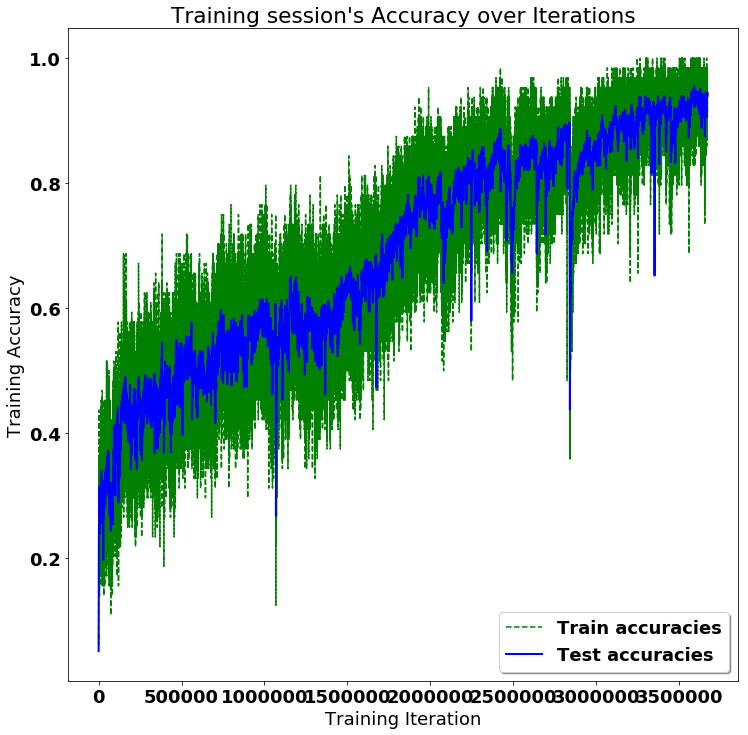

Testing Accuracy: 94.25864219665527%

Precision: 94.35939863181655%
Recall: 94.25863991081383%
f1_score: 94.24626929941138%

Confusion Matrix:
Created using test set of 1794 datapoints, normalised to % of each class in the test dataset


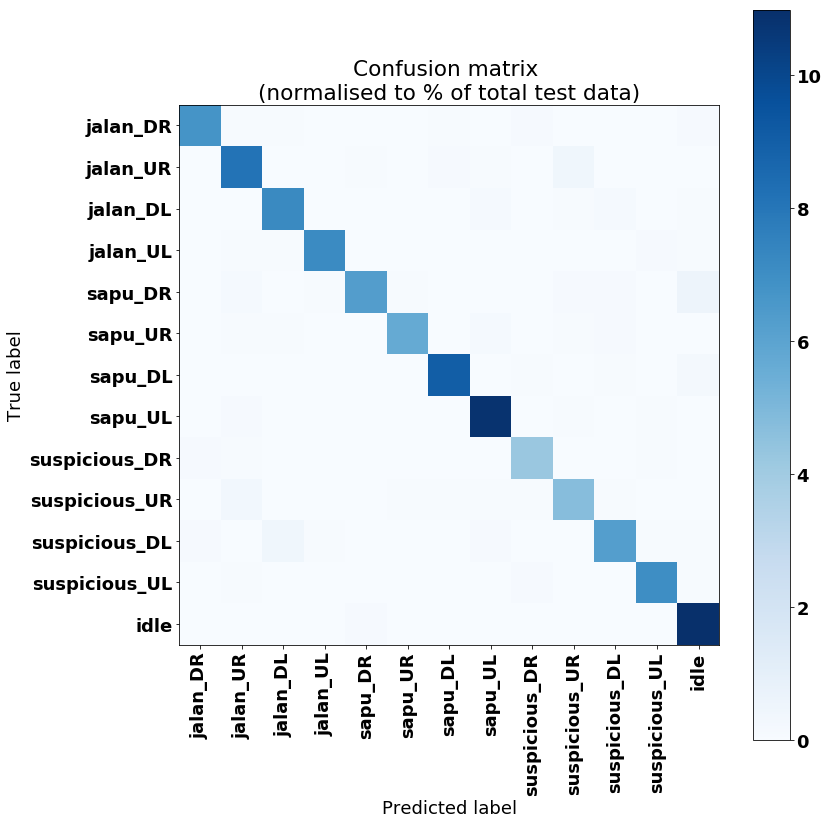

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.051839463, 0.16722408, 0.20345597, 0.24358974, 0.2575251, 0.24916388, 0.25195095, 0.31270903, 0.28093645, 0.27591974, 0.23913044, 0.25585285, 0.2664437, 0.29208472, 0.3160535, 0.29264215, 0.27591974, 0.30211818, 0.27257526, 0.28818282, 0.29208472, 0.2948718, 0.25585285, 0.27369007, 0.26755852, 0.26755852, 0.25696766, 0.31438127, 0.26755852, 0.27313265, 0.27703455, 0.2993311, 0.30156076, 0.32162765, 0.32887402, 0.32998884, 0.319398, 0.3400223, 0.31716833, 0.30156076, 0.29598662, 0.3238573, 0.28483835, 0.31382385, 0.2909699, 0.26309922, 0.26867336, 0.26811594, 0.27982163, 0.29431438, 0.28818282, 0.28874025, 0.26588628, 0.2792642, 0.19732441, 0.22853957, 0.28539577, 0.28874025, 0.27369007, 0.27480492, 0.26867336, 0.26700112, 0.2742475, 0.27090302, 0.32218507, 0.27759197, 0.30100334, 0.29319954, 0.30546266, 0.31772575, 0.30044594, 0.32552955, 0.319398, 0.29431438, 0.31828317, 0.30602008, 0.2826087, 0.30880713, 0.33110368, 0.3154961, 0.29765886, 0.319398, 0.33890748, 0.31270903, 0.309364

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
